# 特斯拉ptt輿情分析

## 動機和分析目的
利用ptt對特斯拉的文章，進行以下的分析，可能的分析方向如下：
+ 社群媒體分析：探索特斯拉在不同社群媒體平台上的評論和討論。如特斯拉的技術創新、環保意識等。
+ 市場趨勢預測：分析特斯拉的新產品發布、重大事件或競爭對手的動態對市場的影響，並進行股市趨勢預測。
+ 產品品質分析：使分析消費者的投訴、讚美和建議，並進行情緒分類和主題分析，探討產品品質的缺點與優點。
+ 競爭分析：分析特斯拉與其他競爭對手的比較。特斯拉和其他汽車品牌的情緒和評價，了解特斯拉市場上的定位和競爭策略。

In [40]:
import time 
import pandas as pd #pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
import numpy as np #numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
import re #re: 正規表達式套件。
import math #math: 數學運算工具。
import datetime
from pprint import pprint
from collections import defaultdict
import multiprocessing
import os
from getpass import getpass
import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt  #matplotlib: 繪圖工具。
import matplotlib.font_manager as fm
import jieba #jieba: 中文斷詞套件。
import jieba.analyse
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker 
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import font_manager
from nltk import ngrams, FreqDist #NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
from collections import Counter, namedtuple #collections: 提供額外的數據類型。
import networkx as nx #networkx: 網絡圖建構、繪製工具。
from snownlp import SnowNLP #SnowNLP 針對中文設計，可以提取句子的情緒分類
# from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
import guidedlda
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
fprop = fm.FontProperties(fname="data/SourceHanSansTW-Regular.otf")


## 資料集
資料來源：
+ 資料來源：tarflow PPT車版
+ 關鍵字：特斯拉、Tesla
+ 停用字：馬司克、Musk 
+ 資料筆數：1585篇
+ 訓練資料日期：2023/1/1 - 2024/04/30

In [41]:
#匯入資料
df = pd.read_csv('./data/ppt_tesla.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
df = df[['artDate','artTitle','artContent']]
df['artDate'] = pd.to_datetime(df['artDate'])
df.head(3)

artDate                  artTitle  \
0 2023-01-01 10:48:19        Re:[情報]慟！特斯拉二手價跌好多   
1 2023-01-01 22:42:25            [問題]特斯拉久了會掉電嗎？   
2 2023-01-02 12:47:31  [新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛   

                                          artContent  
0  八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....  
1  各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...  
2  原文連結：\nhttps://star.setn.com/news/1232578?utm_...

In [42]:
MetaData = df.copy()
MetaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
#MetaData['artDate'] =  pd.to_datetime(MetaData['artDate']).dt.to_period('D')

# 只留下中文字
MetaData['artContent'] = MetaData['artContent'].str.replace("(http|https)://.*", "", regex=True)
MetaData['artTitle'] = MetaData['artTitle'].str.replace("(http|https)://.*", "", regex=True)
MetaData['artContent'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['artTitle'] = MetaData['artTitle'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))


MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['sentence'] = MetaData['sentence'].apply(lambda x: re.sub('[口]', '', x))

MetaData.head(3)

artDate          artTitle  \
0 2023-01-01 10:48:19      情報慟特斯拉二手價跌好多   
1 2023-01-01 22:42:25       問題特斯拉久了會掉電嗎   
2 2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   

                                          artContent  \
0                      八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1  各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                            sentence  
0                      八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎  
1  各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...  
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...

## 情緒分析

In [43]:
df = pd.read_csv('data/ppt_Tesla.csv', encoding = 'UTF-8')
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df["artDate"] = pd.to_datetime(df["artDate"])
clear_df['artDate'] = clear_df['artDate'].dt.date 


# 清理完斷句
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)
sent_df

artUrl  \
0      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
1      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
2      https://www.ptt.cc/bbs/car/M.1672584147.A.632....   
3      https://www.ptt.cc/bbs/car/M.1672584147.A.632....   
4      https://www.ptt.cc/bbs/car/M.1672584147.A.632....   
...                                                  ...   
39017  https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....   
39018  https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....   
39019  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39020  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   

                                   artTitle     artDate  \
0                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
1                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
2                            [問題]特斯拉久了會掉電嗎？  2023-01-01   
3                            [問題]特斯拉久了會掉電嗎？  2023-01-01   
4                            [問題]特斯拉久了會掉電嗎？  2023-01-01   
...                                     ...         ...   
39017     [問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39018     [問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39019  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39020  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   

                                              artContent  \
0      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....   
1      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....   
2      各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...   
3      各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...   
4      各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...   
...                                                  ...   
39017  最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...   
39018  最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...   
39019  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...   
39020  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...   
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...   

                                                sentence  
0                                            八卦是官網特斯拉二手車  
1                                            比很多第三方平台都便宜  
2                                  各位前輩好 想買中古特斯拉里程約5萬上下的  
3          擔心電池久了會掉電越充越少電 里程數越少開了10年後車子變成3c垃圾里程連100公里都不到  
4      另外請問電動車建議買新的還是中古的就好因為有載寵物 就算之後賣中古應該也沒人收但是想要負擔輕...  
...                                                  ...  
39017                                   請問我的用車情境 有更好的選擇嗎  
39018                                                     
39019                 RX吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買Y LR  
39020                                   不過你預算到250有喜歡飆車的話  
39021          那不要LR買Y P我覺得就可以-Sent fromPttXon my iPhone  

[39022 rows x 5 columns]

In [44]:
# 設定jieba
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
2024-06-10 17:52:30,685 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
2024-06-10 17:52:30,686 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
Loading model cost 0.238 seconds.
2024-06-10 17:52:30,924 : DEBUG : Loading model cost 0.238 seconds.
Prefix dict has been built successfully.
2024-06-10 17:52:30,925 : DEBUG : Prefix dict has been built successfully.


artUrl  \
0      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
1      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
2      https://www.ptt.cc/bbs/car/M.1672584147.A.632....   
3      https://www.ptt.cc/bbs/car/M.1672584147.A.632....   
4      https://www.ptt.cc/bbs/car/M.1672584147.A.632....   
...                                                  ...   
39016  https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....   
39017  https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....   
39019  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39020  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   

                                   artTitle     artDate  \
0                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
1                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
2                            [問題]特斯拉久了會掉電嗎？  2023-01-01   
3                            [問題]特斯拉久了會掉電嗎？  2023-01-01   
4                            [問題]特斯拉久了會掉電嗎？  2023-01-01   
...                                     ...         ...   
39016     [問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39017     [問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39019  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39020  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   

                                              artContent  \
0      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....   
1      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....   
2      各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...   
3      各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...   
4      各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...   
...                                                  ...   
39016  最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...   
39017  最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...   
39019  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...   
39020  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...   
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...   

                                                sentence  
0                                            八卦是官網特斯拉二手車  
1                                            比很多第三方平台都便宜  
2                                  各位前輩好 想買中古特斯拉里程約5萬上下的  
3          擔心電池久了會掉電越充越少電 里程數越少開了10年後車子變成3c垃圾里程連100公里都不到  
4      另外請問電動車建議買新的還是中古的就好因為有載寵物 就算之後賣中古應該也沒人收但是想要負擔輕...  
...                                                  ...  
39016                                      爬文版上好像有更優惠的菜單  
39017                                   請問我的用車情境 有更好的選擇嗎  
39019                 RX吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買Y LR  
39020                                   不過你預算到250有喜歡飆車的話  
39021           那不要LR買Y P我覺得就可以Sent fromPttXon my iPhone  

[38111 rows x 5 columns]

In [45]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

artUrl  \
0      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
0      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
0      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
0      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
1      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
...                                                  ...   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   

                                   artTitle     artDate  \
0                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
0                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
0                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
0                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
1                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
...                                     ...         ...   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   

                                              artContent        word  
0      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....          八卦  
0      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....          官網  
0      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....         特斯拉  
0      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....         二手車  
1      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....          很多  
...                                                  ...         ...  
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...          可以  
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...        Sent  
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...  fromPttXon  
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...          my  
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...      iPhone  

[223925 rows x 5 columns]

In [46]:
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

artUrl  \
0      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
0      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
0      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
1      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
1      https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....   
...                                                  ...   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   
39021  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....   

                                   artTitle     artDate  \
0                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
0                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
0                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
1                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
1                        Re:[情報]慟！特斯拉二手價跌好多  2023-01-01   
...                                     ...         ...   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   
39021  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT  2024-04-30   

                                              artContent        word  
0      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....          八卦  
0      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....          官網  
0      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....         二手車  
1      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....          三方  
1      八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....          平台  
...                                                  ...         ...  
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...          LR  
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...        Sent  
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...  fromPttXon  
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...          my  
39021  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...      iPhone  

[165206 rows x 5 columns]

In [47]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

In [48]:
merge_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
merge_df

artUrl     artDate  \
0       https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....  2023-01-01   
1       https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....  2023-01-01   
2       https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....  2023-01-01   
3       https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....  2023-01-01   
4       https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....  2023-01-01   
...                                                   ...         ...   
174471  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....  2024-04-30   
174472  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....  2024-04-30   
174473  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....  2024-04-30   
174474  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....  2024-04-30   
174475  https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....  2024-04-30   

                                    artTitle  \
0                         Re:[情報]慟！特斯拉二手價跌好多   
1                         Re:[情報]慟！特斯拉二手價跌好多   
2                         Re:[情報]慟！特斯拉二手價跌好多   
3                         Re:[情報]慟！特斯拉二手價跌好多   
4                         Re:[情報]慟！特斯拉二手價跌好多   
...                                      ...   
174471  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT   
174472  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT   
174473  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT   
174474  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT   
174475  Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT   

                                               artContent        word  \
0       八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....          八卦   
1       八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....          八卦   
2       八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....          官網   
3       八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....         二手車   
4       八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....          三方   
...                                                   ...         ...   
174471  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...          LR   
174472  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...        Sent   
174473  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...  fromPttXon   
174474  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...          my   
174475  RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...      iPhone   

       sentiments  
0          affect  
1        negative  
2             NaN  
3             NaN  
4             NaN  
...           ...  
174471        NaN  
174472        NaN  
174473        NaN  
174474        NaN  
174475        NaN  

[174476 rows x 6 columns]

In [49]:
sentiment_count = pd.DataFrame(
    merge_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

artDate sentiments  size
3     2023-01-01   negative     4
6     2023-01-02   negative     8
7     2023-01-02   positive     3
10    2023-01-03   negative     3
11    2023-01-03   positive     5
...          ...        ...   ...
1878  2024-04-28   positive    20
1882  2024-04-29   negative     3
1883  2024-04-29   positive     7
1887  2024-04-30   negative    16
1888  2024-04-30   positive     7

[763 rows x 3 columns]

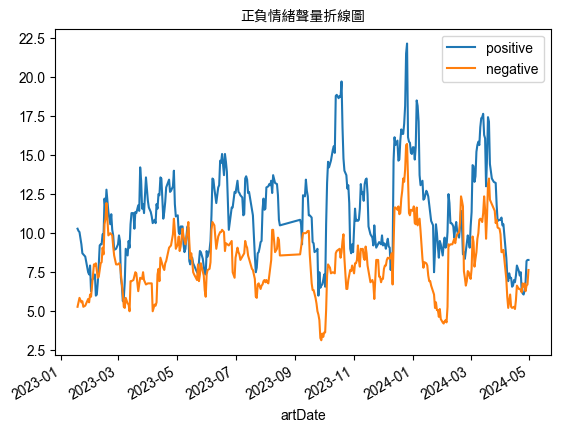

In [50]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

In [52]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

artDate sentiments  size     ratio
3     2023-01-01   negative     4  1.000000
6     2023-01-02   negative     8  0.727273
7     2023-01-02   positive     3  0.272727
10    2023-01-03   negative     3  0.375000
11    2023-01-03   positive     5  0.625000
...          ...        ...   ...       ...
1878  2024-04-28   positive    20  0.714286
1882  2024-04-29   negative     3  0.300000
1883  2024-04-29   positive     7  0.700000
1887  2024-04-30   negative    16  0.695652
1888  2024-04-30   positive     7  0.304348

[763 rows x 4 columns]

Text(0.5, 1.0, '正負情緒比例折線圖')

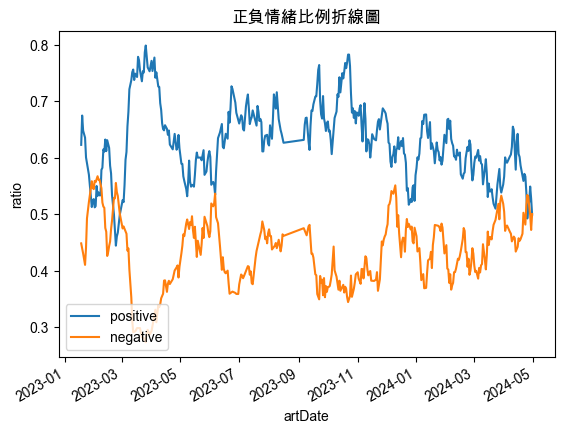

In [53]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

In [56]:
tesla_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
tesla_sentiment_value.head()

artDate  negative  positive
0  2023-01-01       4.0       0.0
1  2023-01-02       8.0       3.0
2  2023-01-03       3.0       5.0
3  2023-01-04       6.0      16.0
4  2023-01-06       4.0       9.0

In [57]:
# sentiment 計算方式: positive - negative
tesla_sentiment_value["sentiment_value"] = (
    tesla_sentiment_value["positive"]
    - tesla_sentiment_value["negative"]
)
tesla_sentiment_value.head()

artDate  negative  positive  sentiment_value
0  2023-01-01       4.0       0.0             -4.0
1  2023-01-02       8.0       3.0             -5.0
2  2023-01-03       3.0       5.0              2.0
3  2023-01-04       6.0      16.0             10.0
4  2023-01-06       4.0       9.0              5.0

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

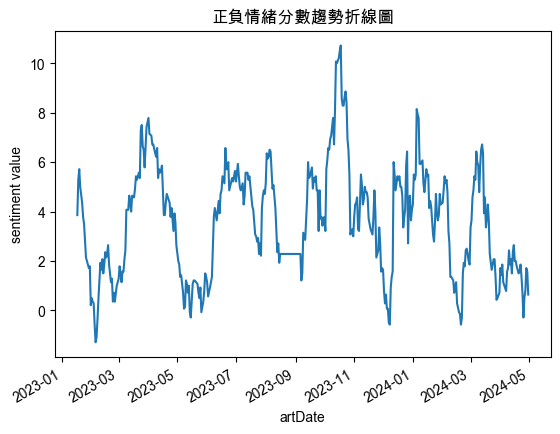

In [58]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(tesla_sentiment_value["artDate"], tesla_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

In [59]:
word_count = merge_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

word sentiments  size
528    安全     affect   228
529    安全   positive   228
64     不錯     affect   127
65     不錯   positive   127
1703   降低        sad   116
...   ...        ...   ...
1370   笨拙   negative     1
302    厭惡   negative     1
728    惡性     affect     1
729    惡性   negative     1
433    堅決     affect     1

[1810 rows x 3 columns]

In [60]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

word sentiments  size
529    安全   positive   228
65     不錯   positive   127
1377   簡單   positive   106
553    容易   positive   104
1672   重要   positive    96
1583   豪華   positive    92
1520   解決   positive    87
199    優勢   positive    82
1092   決定   positive    80
141    保護   positive    71
1342   確定   positive    69
1745   願意   positive    69
1653   適合   positive    68
218    免費   positive    65
1478   舒適   positive    62

In [61]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

word sentiments  size
1702   降低   negative   116
85     事故   negative   115
898    控制   negative    92
1751   風險   negative    68
933    擔心   negative    64
415    嚴重   negative    63
1804   麻煩   negative    58
440    壓力   negative    49
974    故障   negative    47
1768   驚人   negative    45
59     不足   negative    43
1709   隨便   negative    42
1516   衰退   negative    41
295    危險   negative    39
1562   警告   negative    39

In [62]:
filtered_df = sent_df[sent_df['sentence'].str.contains('挑戰', na=False)]
filtered_df.head()

artUrl  \
1564  https://www.ptt.cc/bbs/car/M.1674199727.A.B71....   
1567  https://www.ptt.cc/bbs/car/M.1674199727.A.B71....   
1832  https://www.ptt.cc/bbs/car/M.1675172419.A.BBD....   
3415  https://www.ptt.cc/bbs/car/M.1676449035.A.98F....   
3769  https://www.ptt.cc/bbs/car/M.1676623286.A.8E6....   

                         artTitle     artDate  \
1564  [新聞]ToyotabZ4X出師不利　豐田想提高電動車  2023-01-20   
1567  [新聞]ToyotabZ4X出師不利　豐田想提高電動車  2023-01-20   
1832    [新聞]和台灣市場大不同2022年各國熱賣車款出爐  2023-01-31   
3415  [新聞]2023年全球電動車電池裝機量將達749GWh  2023-02-15   
3769    [新聞]曾被認為可挑戰特斯拉的Rivian改變戰略  2023-02-17   

                                             artContent  \
1564  Toyota bZ4X出師不利　豐田想提高電動車銷量遇上「前所未見」的挑戰\n經濟日報 編譯...   
1567  Toyota bZ4X出師不利　豐田想提高電動車銷量遇上「前所未見」的挑戰\n經濟日報 編譯...   
1832  原文連結：\nhttps://autos.udn.com/autos/story/7826/...   
3415  原文連結：\nhttps://bit.ly/3Eaxwxn\n原文內容：\n根據韓國研究機構...   
3769  曾被認為可挑戰特斯拉的Rivian，改變戰略，往電動自行車市場前進\n\n原文連結：\nht...   

                                               sentence  
1564  Toyota bZ4X出師不利　豐田想提高電動車銷量遇上前所未見的挑戰經濟日報 編譯季晶晶綜合外電  
1567                         全球最大車廠提升電動車銷售的努力正面臨前所未見的挑戰  
1832                                        考慮到全球所面臨的挑戰  
3415                                           未來也將面臨挑戰  
3769                                  曾被認為可挑戰特斯拉的Rivian

Text(0.5, 1.0, '負向情緒總數')

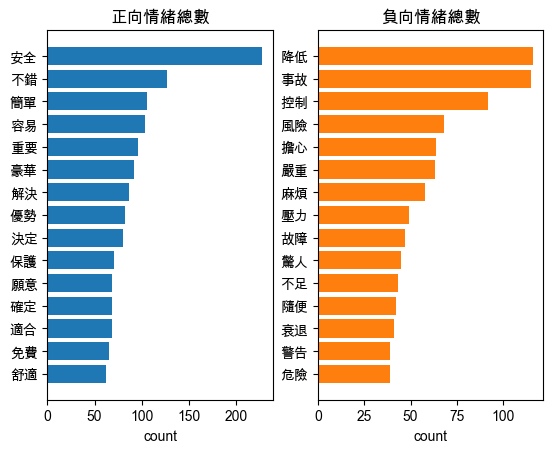

In [63]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

In [64]:
# 設定要移除的字詞列表
words_to_remove = ['問題', '願意', '擔心', '決定', '隨便', '強烈', '負擔', '口吃', '挑剔', '壓力', '邪惡', '禁止',
                   '挑戰', '謝謝', '智能', '智慧','確定','解決']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[[ "artDate", "artTitle", "artContent", "word"]], liwc_dict_revise,
                              how="left")
ptt_liwc_df_revise.head()

artDate            artTitle  \
0  2023-01-01  Re:[情報]慟！特斯拉二手價跌好多   
1  2023-01-01  Re:[情報]慟！特斯拉二手價跌好多   
2  2023-01-01  Re:[情報]慟！特斯拉二手價跌好多   
3  2023-01-01  Re:[情報]慟！特斯拉二手價跌好多   
4  2023-01-01  Re:[情報]慟！特斯拉二手價跌好多   

                                          artContent word sentiments  
0  八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....   八卦     affect  
1  八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....   八卦   negative  
2  八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....   官網        NaN  
3  八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....  二手車        NaN  
4  八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....   三方        NaN

Text(0.5, 1.0, '負向情緒總數')

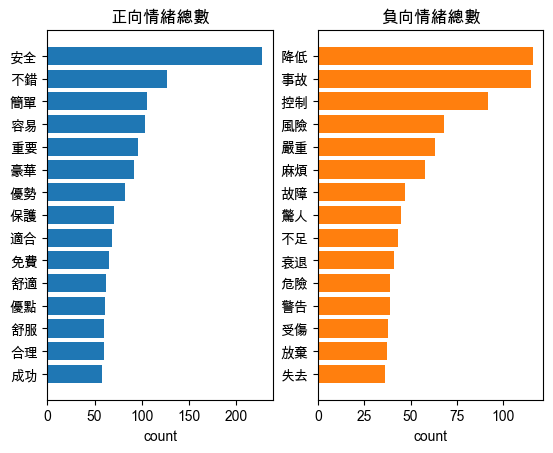

In [65]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

## 標注文章
三種方式 : guilda、bert_Topic、prompt engineering

### 載入HuggingfaceAPI

In [2]:
HUGGINGFACEHUB_API_TOKEN = getpass()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

### 使用HuggingFaceEndPoint with google/gemma-1.1-7b-it

In [ ]:
llm = HuggingFaceEndpoint(
    repo_id="google/gemma-1.1-7b-it", temperature=1.0,model_kwargs={'token':HUGGINGFACEHUB_API_TOKEN, 'use_cache':False}
)

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from langchain-huggingface package and should be used instead. To use it run `pip install -U from langchain-huggingface` and import as `from from langchain_huggingface import llms import HuggingFaceEndpoint`.
  warn_deprecated(


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/aiden/.cache/huggingface/token
Login successful


### 產生prompt模板

In [ ]:
class ArticleClassification(BaseModel):
    文章分類: str = Field(..., description="分類此文章的主題。", enum=["服務方面", "車輛交付方面", "性價比方面", "安全性方面", "使用者體驗"])
    情緒: str = Field(..., description="判斷整篇文章的總體情緒。", enum=["正向", "中性", "負向"])

article_parser = JsonOutputParser(pydantic_object=ArticleClassification)

In [ ]:
# Few-shot Template
fewshot_template = """<start_of_turn>user
你是一個強大的語言模型，能夠根據給定的文本進行分類。
請抓取每一篇文章，進行分類與情緒分類。

1.評論此文章的情緒，正向或負向或中性
2.分類此文章，共有a-e共種分類，請將文章進行分類
    a. 服務方面：特斯拉售前、售後整體過程之服務。
    b. 車輛交付方面：從下訂單到車輛交付的方面。
    c. 性價比方面：衡量特斯拉價格與其所能提供的能力
    d. 安全性方面：特斯拉的主動和被動安全措施、電池安全、充電安全以及整車安全設計等多個方面。
    e. 使用者體驗：從車輛的駕駛感受、操作界面、智慧化功能到軟硬體支援等多個面向的體驗。

以下為一些範例
```
範例1
句子：這款電動車雖然價格不便宜，但確實是物有所值
抓取結果：{{
    "文章分類":"性價比方面",
    "情緒":"正面",
}}

範例2
句子：特斯拉的客服服務真的很友善，幫助我解決了很多問題
抓取結果：{{
    "文章分類":"服務方面",
    "情緒":"正面",
}}

範例3
句子：我最近買了特斯拉的 Model 3，車輛交付的速度真的很快
抓取結果：{{
    "文章分類":"車輛交付方面",
    "情緒":"正面",
}}

範例4
句子：相同的電動車，特斯拉的蓄電量較低然後又比較貴
抓取結果：{{
    "文章分類":"性價比方面",
    "情緒":"負面",
}}

範例5
句子：我最近發生了一次車禍，幸好特斯拉的安全措施幫助我避免了更嚴重的損害
抓取結果：{{
    "文章分類":"安全性方面",
    "情緒":"正面",
}}

範例6
句子：特斯拉的操作界面真的很友善，讓我很容易上手
抓取結果：{{
    "文章分類":"使用者體驗",
    "情緒":"正面",
}}

範例7
句子：特斯拉的客服服務真的很慢，需要等很久才能解決問題
抓取結果：{{
    "文章分類":"服務方面",
    "情緒":"負面",
}}

範例8
句子：我最近買了特斯拉的 Model S，車輛交付的速度真的很慢
抓取結果：{{
    "文章分類":"車輛交付方面",
    "情緒":"負面",
}}

範例9
句子：特斯拉的價格真的很高，沒有太多的選擇
抓取結果：{{
    "文章分類":"性價比方面",
    "情緒":"負面",
}}

範例10
句子：特斯拉的安全措施真的很好，讓我感到很安全
抓取結果：{{
    "文章分類":"安全性方面",
    "情緒":"正面",
}}

範例11
句子：特斯拉的操作界面真的很複雜，需要花很多時間學習
抓取結果：{{
    "文章分類":"使用者體驗",
    "情緒":"負面",
}}

範例12
句子：特斯拉的車子失控，我無法正常駕駛他
抓取結果：{{
    "文章分類":"安全性方面",
    "情緒":"負面",
}}


{format_instructions}
請使用繁體中文回答。
除了 JSON 內容外，不要回答任何其他內容

現在請回答以下問題：
文本：{text}
抓取結果：<end_of_turn>
<start_of_turn>model
"""


article_prompt = PromptTemplate(
    template=fewshot_template,
    input_variables=["text"],
    partial_variables={"format_instructions": article_parser.get_format_instructions()},
)

chain = article_prompt | llm


### 定義函式：萃取LLMs回答的結果

In [ ]:
import json

# 從 json 字串中抓取答案
def extract_answer_from_string(string_):
    string_ = string_.replace("\n", "")
    string_ = string_.replace("json", "")
    string_ = string_.replace("    ", "")
    string_ = string_.replace("```", "")
    try:
        dict_result = json.loads(string_)
    except:
        print(string_)
        return string_
    return dict_result

# 從 dict 抓取情緒
def get_sentiment(row):
    try:
        # 去除多餘的空格和換行符號
        cleaned_row = row.replace(' ', '').replace('\n', '').replace('\r', '')
        # 確保最後一個符號不是逗號
        if cleaned_row.endswith(',}'):
            cleaned_row = cleaned_row.replace(',}', '}')
        data = json.loads(cleaned_row)
        return data.get('情緒', None)
    except (json.JSONDecodeError, TypeError, AttributeError):
        return None

# 從 dict 抓取文章分類
def get_classification(row):
    try:
        # 去除多餘的空格和換行符號
        cleaned_row = row.replace(' ', '').replace('\n', '').replace('\r', '')
        # 確保最後一個符號不是逗號
        if cleaned_row.endswith(',}'):
            cleaned_row = cleaned_row.replace(',}', '}')
        data = json.loads(cleaned_row)
        return data.get('文章分類', None)
    except (json.JSONDecodeError, TypeError, AttributeError):
        return None

### 將原始資料拆分12份，進丟進LLMs運行

In [ ]:
# 將MetaData拆分成12份
split_dfs = np.array_split(MetaData, 12)

# 定義一個函數來處理每個分割的資料
def process_split_df(split_df, index):
    split_df['LLM'] = split_df['artContent'].apply(lambda x: extract_answer_from_string(chain.invoke({"text": x})))
    split_df['sentiment'] = split_df['LLM'].apply(get_sentiment)
    split_df['class'] = split_df['LLM'].apply(get_classification)
    split_df.to_csv(f'./data/ppt_tesla_classified_part_{index}.csv', index=False, encoding='UTF-8')

# 逐個處理每個分割的資料
for i in range(0, 12):
    print(f"Processing part {i}")
    process_split_df(split_dfs[i], i)

### 將12份運行結果合併

In [ ]:
# 讀取所有 CSV 檔案並合併為一個 DataFrame
llms_class = pd.concat([
    pd.read_csv('./data/ppt_tesla_classified_part_0.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_1.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_2.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_3.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_4.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_5.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_6.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_7.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_8.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_9.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_10.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_11.csv', encoding='UTF-8')
], ignore_index=True)

# 重設 index 並將新的 index 命名為 'system_id'
llms_class = llms_class.reset_index().rename(columns={'index': 'system_id'})
llms_class = llms_class.rename(columns={'情緒': 'sentiment'})
llms_class = llms_class.rename(columns={'文章分類': 'class'})
# 顯示更新後的 DataFrame
llms_class

system_id              artDate             artTitle  \
0             0  2023-01-01 10:48:19         情報慟特斯拉二手價跌好多   
1             1  2023-01-01 22:42:25          問題特斯拉久了會掉電嗎   
2             2  2023-01-02 12:47:31     新聞開特斯拉滑手機被勸嗆網友有毛   
3             3  2023-01-02 18:01:04   討論是不是真的有些四輪覺得自己是大爺   
4             4  2023-01-02 19:21:24    新聞美國汽車召回排名揭曉第一名超過   
...         ...                  ...                  ...   
1580       1580  2024-04-30 10:33:35     新聞特斯拉全新入門電動車準備量產   
1581       1581  2024-04-30 12:24:31              分享撞緩撞車啦   
1582       1582  2024-04-30 17:45:19  新聞銷售降溫賓士上季獲利銳減逾三成福斯   
1583       1583  2024-04-30 19:19:58                   問題   
1584       1584  2024-04-30 19:53:28                   問題   

                                             artContent  \
0                         八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1     各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
2     原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3     如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
4     原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
...                                                 ...   
1580  哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...   
1581  要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...   
1582  都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...   
1583  最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...   
1584  吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...   

                                               sentence  \
0                         八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1     各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
2     原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3     如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
4     原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
...                                                 ...   
1580  哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...   
1581  要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...   
1582  都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...   
1583  最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...   
1584  吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...   

                                                    LLM  sentiment  class  
0                         {"文章分類": "性價比方面","情緒": "正面",}        NaN    NaN  
1                           {"文章分類":"性價比方面","情緒":"負面",}        NaN    NaN  
2     {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        NaN    NaN  
3                           {"文章分類":"使用者體驗","情緒":"負面",}        NaN    NaN  
4                         {"文章分類": "性價比方面","情緒": "負面",}        NaN    NaN  
...                                                 ...        ...    ...  
1580                      {"文章分類": "性價比方面","情緒": "正面",}        NaN    NaN  
1581  {"文章分類": "政策與法規方面","情緒": "正面","內容": "要系統性的改善緩撞...        NaN    NaN  
1582                       {"文章分類": "使用者體驗","情緒": "正面"}        NaN    NaN  
1583                      {"文章分類": "性價比方面","情緒": "負面",}        NaN    NaN  
1584                      {"文章分類": "性價比方面","情緒": "負面",}        NaN    NaN  

[1585 rows x 8 columns]

### 提取LLMs回答的內容，產生「文章分類」、「文章情緒」兩個標籤

In [ ]:
llms_class['sentiment'] = llms_class['LLM'].apply(get_sentiment)
llms_class['class'] = llms_class['LLM'].apply(get_classification)

# 儲存清理後的結果，只保留指定欄位
llms_class.to_csv('./data/ppt_tesla_classified_cleaned.csv', index=False, encoding='UTF-8')
llms_class

system_id              artDate             artTitle  \
0             0  2023-01-01 10:48:19         情報慟特斯拉二手價跌好多   
1             1  2023-01-01 22:42:25          問題特斯拉久了會掉電嗎   
2             2  2023-01-02 12:47:31     新聞開特斯拉滑手機被勸嗆網友有毛   
3             3  2023-01-02 18:01:04   討論是不是真的有些四輪覺得自己是大爺   
4             4  2023-01-02 19:21:24    新聞美國汽車召回排名揭曉第一名超過   
...         ...                  ...                  ...   
1580       1580  2024-04-30 10:33:35     新聞特斯拉全新入門電動車準備量產   
1581       1581  2024-04-30 12:24:31              分享撞緩撞車啦   
1582       1582  2024-04-30 17:45:19  新聞銷售降溫賓士上季獲利銳減逾三成福斯   
1583       1583  2024-04-30 19:19:58                   問題   
1584       1584  2024-04-30 19:53:28                   問題   

                                             artContent  \
0                         八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1     各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
2     原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3     如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
4     原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
...                                                 ...   
1580  哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...   
1581  要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...   
1582  都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...   
1583  最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...   
1584  吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...   

                                               sentence  \
0                         八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1     各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
2     原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3     如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
4     原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
...                                                 ...   
1580  哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...   
1581  要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...   
1582  都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...   
1583  最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...   
1584  吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...   

                                                    LLM sentiment    class  
0                         {"文章分類": "性價比方面","情緒": "正面",}        正面    性價比方面  
1                           {"文章分類":"性價比方面","情緒":"負面",}        負面    性價比方面  
2     {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面    使用者體驗  
3                           {"文章分類":"使用者體驗","情緒":"負面",}        負面    使用者體驗  
4                         {"文章分類": "性價比方面","情緒": "負面",}        負面    性價比方面  
...                                                 ...       ...      ...  
1580                      {"文章分類": "性價比方面","情緒": "正面",}        正面    性價比方面  
1581  {"文章分類": "政策與法規方面","情緒": "正面","內容": "要系統性的改善緩撞...        正面  政策與法規方面  
1582                       {"文章分類": "使用者體驗","情緒": "正面"}        正面    使用者體驗  
1583                      {"文章分類": "性價比方面","情緒": "負面",}        負面    性價比方面  
1584                      {"文章分類": "性價比方面","情緒": "負面",}        負面    性價比方面  

[1585 rows x 8 columns]

###  1. Guild LDA

In [54]:
FontPath = 'data/SourceHanSansTW-Regular.otf' # 設定字型
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False

In [55]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

這邊只保留ppt特斯拉版的日期、標題與內容

In [6]:
df = pd.read_csv('data/ppt_Tesla.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
df = df[['artDate','artTitle','artContent']]
df['artDate'] = pd.to_datetime(df['artDate'])
df.head(3)

artDate                  artTitle  \
0 2023-01-01 10:48:19        Re:[情報]慟！特斯拉二手價跌好多   
1 2023-01-01 22:42:25            [問題]特斯拉久了會掉電嗎？   
2 2023-01-02 12:47:31  [新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛   

                                          artContent  
0  八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....  
1  各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...  
2  原文連結：\nhttps://star.setn.com/news/1232578?utm_...

進行前處理，這邊再分出一個topic label欄位

In [7]:
car = df.copy()
car["artContent"] = car["artContent"].str.replace("(http|https)://.*", "", regex=True)
car["artTitle"] = car["artTitle"].str.replace("(http|https)://.*", "", regex=True)
car["artContent"] = car["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
car["artTitle"] = car["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
car['content'] = car['artContent']
car['topic_label']= ""
car

artDate             artTitle  \
0    2023-01-01 10:48:19         情報慟特斯拉二手價跌好多   
1    2023-01-01 22:42:25          問題特斯拉久了會掉電嗎   
2    2023-01-02 12:47:31     新聞開特斯拉滑手機被勸嗆網友有毛   
3    2023-01-02 18:01:04   討論是不是真的有些四輪覺得自己是大爺   
4    2023-01-02 19:21:24    新聞美國汽車召回排名揭曉第一名超過   
...                  ...                  ...   
1581 2024-04-30 10:33:35     新聞特斯拉全新入門電動車準備量產   
1582 2024-04-30 12:24:31              分享撞緩撞車啦   
1583 2024-04-30 17:45:19  新聞銷售降溫賓士上季獲利銳減逾三成福斯   
1584 2024-04-30 19:19:58                   問題   
1585 2024-04-30 19:53:28                   問題   

                                             artContent  \
0                         八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1     各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
2     原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3     如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
4     原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
...                                                 ...   
1581  哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...   
1582  要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...   
1583  都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...   
1584  最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...   
1585  吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...   

                                                content topic_label  
0                         八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎              
1     各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...              
2     原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...              
3     如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...              
4     原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...              
...                                                 ...         ...  
1581  哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...              
1582  要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...              
1583  都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...              
1584  最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...              
1585  吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...              

[1585 rows x 5 columns]

設定斷詞跟停用字

In [73]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stopwords.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

car["words"] = car["content"].apply(getToken)
car.head()

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt.big ...
2024-06-10 17:57:16,048 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt.big ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.u160d5499c10b2133fd820e5821d8ed10.cache
2024-06-10 17:57:16,049 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.u160d5499c10b2133fd820e5821d8ed10.cache
Loading model cost 0.510 seconds.
2024-06-10 17:57:16,559 : DEBUG : Loading model cost 0.510 seconds.
Prefix dict has been built successfully.
2024-06-10 17:57:16,559 : DEBUG : Prefix dict has been built successfully.


artDate            artTitle  \
0 2023-01-01 10:48:19        情報慟特斯拉二手價跌好多   
1 2023-01-01 22:42:25         問題特斯拉久了會掉電嗎   
2 2023-01-02 12:47:31    新聞開特斯拉滑手機被勸嗆網友有毛   
3 2023-01-02 18:01:04  討論是不是真的有些四輪覺得自己是大爺   
4 2023-01-02 19:21:24   新聞美國汽車召回排名揭曉第一名超過   

                                          artContent  \
0                      八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1  各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3  如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
4  原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   

                                             content topic_label  \
0                      八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎               
1  各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...               
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...               
3  如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...               
4  原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...               

                                               words  
0                 [八卦, 官網, 二手車, 第三方, 平台, 便宜, 黨會, 勝利]  
1  [前輩, 中古, 里程, 擔心, 電池, 掉電, 越充, 越少電, 里程, 數越, 少開, ...  
2  [王家, 徐兆緯, 前電, 世界冠軍, 日前, 直播, 駕駛, 雙手, 離開, 方向盤, 不...  
3  [出門, 車位, 很煩, 騎家裡, 超舊, 路上, 有機, 車道, 靠邊, 不爭, 蛇行, ...  
4  [汽車, 召回, 排名, 揭曉, 第一名, 萬輛, 進廠, 結束, 迎來, 許多年, 數據,...

In [9]:
docs = car['words'].to_list()
docs[0]

['八卦', '官網', '二手車', '第三方', '平台', '便宜', '黨會', '勝利']

In [10]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-06-10 16:19:12,074 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-06-10 16:19:12,173 : INFO : built Dictionary<28504 unique tokens: ['二手車', '便宜', '八卦', '勝利', '官網']...> from 1585 documents (total 165532 corpus positions)
2024-06-10 16:19:12,174 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<28504 unique tokens: ['二手車', '便宜', '八卦', '勝利', '官網']...> from 1585 documents (total 165532 corpus positions)", 'datetime': '2024-06-10T16:19:12.174157', 'gensim': '4.3.2', 'python': '3.8.18 (default, Sep 11 2023, 08:25:43) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'created'}
2024-06-10 16:19:12,185 : INFO : discarding 23875 tokens: [('黨會', 1), ('寵物', 4), ('少開', 1), ('掉電', 4), ('數越', 1), ('有載', 2), ('沒人收', 1), ('越充', 1), ('越少電', 1), ('一拳', 2)]...
2024-06-10 16:19:12,186 : INFO : keeping 4629 tokens which were in no less than 5 and no more than 1569 (=99.0%) documents
2024-06-10 16:19:12,191 : INFO : resulting dictionary: Dictionar

Dictionary<4629 unique tokens: ['二手車', '便宜', '八卦', '勝利', '官網']...>


In [11]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

二手車: 0
便宜: 1
八卦: 2
勝利: 3
官網: 4
平台: 5
第三方: 6
不到: 7
中古: 8
公里: 9
利率: 10
前輩: 11


In [12]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
type(corpus)

list

In [13]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('二手車', '便宜', '八卦', '勝利', '官網', '平台', '第三方', '不到', '中古', '公里')

In [80]:
word2id = dictionary.token2id

我們主要的目的是去找出抱怨相關的主題，而其中又把這些主體細分成有：服務方面、車輛交付方面、性價比方面、安全性方面、使用者體驗方面。
而對應上述五個面向的順序而產生以下的seed list

In [81]:
seed_topic_list = [
    ["服務", "員工", "品質", "後勤", "更換", "速度","態度"],
    ["設備", "交付", "延遲", "據點","原廠"],
    ["價格","優惠","打折","折價"],
    ["安全", "過熱", "火車", "爆炸", "失控","召回","系統","自駕","煞車"],
    ["體驗", "駕駛", "操控", "公差","里程","續航力","加速","噪音","焦慮"],
]

In [82]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [83]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [84]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-06-06 18:30:03,725 : INFO : n_documents: 1585
2024-06-06 18:30:03,725 : INFO : vocab_size: 4653
2024-06-06 18:30:03,725 : INFO : n_words: 128719
2024-06-06 18:30:03,726 : INFO : n_topics: 6
2024-06-06 18:30:03,726 : INFO : n_iter: 100
2024-06-06 18:30:03,730 : WARNING : all zero row in document-term matrix found
2024-06-06 18:30:04,170 : INFO : <0> log likelihood: -1342612
2024-06-06 18:30:04,287 : INFO : <20> log likelihood: -1043714
2024-06-06 18:30:04,401 : INFO : <40> log likelihood: -1027813
2024-06-06 18:30:04,515 : INFO : <60> log likelihood: -1020161
2024-06-06 18:30:04,629 : INFO : <80> log likelihood: -1016380
2024-06-06 18:30:04,742 : INFO : <99> log likelihood: -1013556


此處是Guild LDA所分出的主題，我們透過選出前20個字來查看LDA所分出的主題跟我們所預期的是否一致
而參數設定上，我們多分出第六類者題最為其他以劃分不在上述五個主題的文章。

In [85]:
# 整理／顯示主題模型結果
n_top_words = 20
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 電動車 電池 充電 美國 美元 安全 指出 車體 採用 規格 新聞 網址 相關 續航 標準 意見 標點符號 汽車 調查 保險公司
Topic 1: 電動車 中國 汽車 市場 品牌 銷售 美國 歐洲 銷量 豐田 萬輛 全球 比亞迪 製造商 車廠 日本 成長 技術 福特 德國
Topic 2: 台灣 降價 售價 車型 交車 車馬費 活動 台北市 網頁 新車 汽車 購車 台幣 專案 地點 車系 符合 訪問 掛牌 訂單
Topic 3: 駕駛 系統 功能 輔助 空間 方向盤 後座 設計 煞車 更新 螢幕 安全 召回 油門 踏板 軟體 座椅 原廠 體驗 車廠
Topic 4: 充電 駕駛 公里 車道 開車 車子 停車 停車場 情況 超充 車上 車禍 突然 國道 這種 原因 冷氣 注意 高速公路 分鐘
Topic 5: 電車 台灣 油車 電池 價格 便宜 充電 車子 電動車 品牌 里程 保養 這種 業務 根本 看看 選擇 不到 二手 只能


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.152631  0.239436       1        1  23.031315
5      0.026132 -0.056387       2        1  21.239823
4      0.226284 -0.149014       3        1  19.041765
3      0.208320  0.061650       4        1  16.554816
0     -0.047545  0.159440       5        1  13.614297
2     -0.260561 -0.255126       6        1   6.517985, topic_info=     Term         Freq        Total Category  logprob  loglift
24    電動車  2136.000000  2136.000000  Default  30.0000  30.0000
339    中國  1162.000000  1162.000000  Default  29.0000  29.0000
401    充電  1398.000000  1398.000000  Default  28.0000  28.0000
25     電池   925.000000   925.000000  Default  27.0000  27.0000
92     駕駛   976.000000   976.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
142    資料    58.760353   135.653814   Topic6  -4.9613   1.8940
1202   國內    48.802659    91.782289   Topic6  -5.1470   2.0990
125    汽車    94.608053  1126.967858   Topic6  -4.4850   0.2531
344    價格    54.777276   392.144716   Topic6  -5.0315   0.7622
353    品牌    45.815351   667.802586   Topic6  -5.2102   0.0512

[403 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
277       3  0.979072    一名
277       6  0.021757    一名
1092      2  0.749357    一堆
1092      3  0.091758    一堆
1092      4  0.160576    一堆
...     ...       ...   ...
2407      4  0.826342    體驗
2407      6  0.008347    體驗
336       1  0.030973  高速公路
336       3  0.815626  高速公路
336       4  0.154866  高速公路

[629 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 5, 4, 1, 3])

In [86]:
topics_doc = model.transform(X)
print(len(doc_topic))

2024-06-06 18:31:12,145 : WARNING : all zero row in document-term matrix found


1585


In [87]:
for i in range(len(doc_topic)):
    print("topic :{} Document: {}".format(doc_topic[i].argmax(), ', '.join(np.array(vocab)[list(reversed(X[i,:].argsort()))[0:5]])))
    car['topic_label'][i] = doc_topic[i].argmax()

topic :5 Document: 二手車, 便宜, 八卦, 勝利, 官網
topic :5 Document: 中古, 里程, 建議, 新車, 垃圾
topic :4 Document: 開車, 直播, 方向盤, 危險, 駕駛
topic :4 Document: 四輪, 騎車, 很煩, 國產車, 路上
topic :1 Document: 召回, 萬輛, 美國, 福特, 汽車
topic :0 Document: 按摩, 展開, 暫時, 更是, 最早
topic :3 Document: 召回, 回廠, 台車, 車子, 更新
topic :1 Document: 萬輛, 交付, 第四季, 數據, 交車
topic :1 Document: 銷售, 進口, 掛牌, 冠軍, 本月
topic :4 Document: 一名, 罕見, 車上, 並未, 事故
topic :1 Document: 汽車, 一汽, 本田, 大眾, 豐田
topic :5 Document: 意外, 整理, 排名, 耗油, 排行榜
topic :0 Document: 充電, 南韓, 電動車, 里程, 續航
topic :0 Document: 充電, 北美, 續航, 零下, 里程
topic :2 Document: 台幣, 人民幣, 售價, 大陸, 降價
topic :5 Document: 供給, 需求, 自然, 降低, 說過
topic :4 Document: 充電, 國道, 服務區, 車位, 充站
topic :1 Document: 降價, 大陸, 市場, 來到, 新台幣
topic :0 Document: 來源, 按摩, 榜單, 更是, 最早
topic :1 Document: 澳洲, 銷量, 電動車, 霸主, 房車
topic :3 Document: 改裝, 加個, 車子, 白色, 少數
topic :0 Document: 電動車, 火災, 撲滅, 火燒, 最終
topic :2 Document: 台灣, 降價, 售價, 掛牌, 中國
topic :1 Document: 汽車, 軟體, 定義, 遊戲, 趨勢
topic :5 Document: 方便, 這台, 含稅, 同事, 充電
topic :4 Document: 車頭, 牌子, 馬自達, 鼻孔, 有名


In [88]:
car.head(20)

artDate             artTitle  \
0  2023-01-01 10:48:19         情報慟特斯拉二手價跌好多   
1  2023-01-01 22:42:25          問題特斯拉久了會掉電嗎   
2  2023-01-02 12:47:31     新聞開特斯拉滑手機被勸嗆網友有毛   
3  2023-01-02 18:01:04   討論是不是真的有些四輪覺得自己是大爺   
4  2023-01-02 19:21:24    新聞美國汽車召回排名揭曉第一名超過   
5  2023-01-02 22:03:33    新聞美國汽車召回排名揭曉第一名超過   
6  2023-01-03 10:14:48    新聞美國汽車召回排名揭曉第一名超過   
7  2023-01-03 12:31:28     新聞又是破紀錄的一年特斯拉年交車   
8  2023-01-03 12:32:48      情報年月份臺灣汽車市場銷售報告   
9  2023-01-04 09:55:23    新聞人奇蹟生還特斯拉衝破公路圍欄墜   
10 2023-01-04 10:00:54    新聞和泰汽車連續年稱霸台灣車市銷售   
11 2023-01-04 10:21:07             分享電動車排行榜   
12 2023-01-04 11:44:35    新聞特斯拉誇大續航力南韓裁罰億韓元   
13 2023-01-04 18:46:43       新聞誠實為上主動告知在這條件   
14 2023-01-06 11:14:29       新聞特斯拉跳水大降價台灣大陸   
15 2023-01-06 17:08:33       新聞特斯拉跳水大降價台灣大陸   
16 2023-01-06 22:03:36  新聞國道電動車充電站第三期準備招標個服   
17 2023-01-07 10:58:15          新聞日韓大陸都降價台灣   
18 2023-01-07 13:56:38                 情報英國   
19 2023-01-07 15:21:05     新聞全年銷量稱霸澳洲中型房車類別   

                                           artContent  \
0                       八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1   各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
2   原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3   如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
4   原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
5                                                       
6   先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...   
7   原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...   
8   月份台灣新車市場共掛牌輛電動車賣到第一名絕對是亮點先來看看進口和國產前名還有哪些車款進榜稍後...   
9   原文連結原文內容人奇蹟生還特斯拉衝破公路圍欄墜公尺懸崖成廢鐵聯合報編譯張君堯即時報導美國加州...   
10  笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...   
11          電動車排行榜出來了不意外是輾壓意外的是排名蠻前面的只是聽說韓車很耗油以上資料為整理   
12  特斯拉誇大續航力南韓裁罰億韓元原文連結原文內容自由時報編譯魏國金綜合報導南韓反壟斷監管機關公...   
13  原文連結原文內容誠實為上北美主動告知消費者在這條件下可能會無法充電人看過美規不久前在韓國市場...   
14  原文連結原文內容特斯拉跳水大降價台灣大陸價差萬創新高記者鄧光惟綜合報導特斯拉要跟中國大陸國產...   
15  沒讀過經濟學是不是亞當史密斯說過有一雙看不見的手供給需求來平衡市場今天消費者覺得太貴自然不會...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
17  日韓大陸都降價台灣價差將近百萬原文連結原文內容似乎打算在今年強勢拚市佔率不僅在大陸市場大降價...   
18                                                 來源   
19  原文連結原文內容全年銷量稱霸澳洲中型房車類別終結長達年的霸主地位純電休旅是特斯拉當前最夯的明...   

                                              content topic_label  \
0                       八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎           5   
1   各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...           5   
2   原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...           4   
3   如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...           4   
4   原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...           1   
5                                                               0   
6   先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...           3   
7   原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...           1   
8   月份台灣新車市場共掛牌輛電動車賣到第一名絕對是亮點先來看看進口和國產前名還有哪些車款進榜稍後...           1   
9   原文連結原文內容人奇蹟生還特斯拉衝破公路圍欄墜公尺懸崖成廢鐵聯合報編譯張君堯即時報導美國加州...           4   
10  笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...           1   
11          電動車排行榜出來了不意外是輾壓意外的是排名蠻前面的只是聽說韓車很耗油以上資料為整理           5   
12  特斯拉誇大續航力南韓裁罰億韓元原文連結原文內容自由時報編譯魏國金綜合報導南韓反壟斷監管機關公...           0   
13  原文連結原文內容誠實為上北美主動告知消費者在這條件下可能會無法充電人看過美規不久前在韓國市場...           0   
14  原文連結原文內容特斯拉跳水大降價台灣大陸價差萬創新高記者鄧光惟綜合報導特斯拉要跟中國大陸國產...           2   
15  沒讀過經濟學是不是亞當史密斯說過有一雙看不見的手供給需求來平衡市場今天消費者覺得太貴自然不會...           5   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...           4   
17  日韓大陸都降價台灣價差將近百萬原文連結原文內容似乎打算在今年強勢拚市佔率不僅在大陸市場大降價...           1   
18                                                 來源           0   
19  原文連結原文內容全年銷量稱霸澳洲中型房車類別終結長達年的霸主地位純電休旅是特斯拉當前最夯的明...           1   

                                                words  
0                  [八卦, 官網, 二手車, 第三方, 平台, 便宜, 黨會, 勝利]  
1   [前輩, 中古, 里程, 擔心, 電池, 掉電, 越充, 越少電, 里程, 數越, 少開, ...  
2   [王家, 徐兆緯, 台北, 前電, 世界冠軍, 日前, 直播, 駕駛, 雙手, 完全, 離開...  
3   [出門, 車位, 很煩, 騎家裡, 超舊, 路上, 有機, 車道, 靠邊, 不爭, 蛇行, ...  
4   [美國, 汽車, 召回, 排名, 揭曉, 第一名, 超過, 萬輛, 進廠, 結束, 迎來, ...  
5                                          

## 安全性方面深入分析

##### 在安全性方面，透過LLM分出的結果以查看其所分出的正負面相關多字詞

In [14]:
df = pd.read_csv("data/ppt_tesla_classified_cleaned.csv")
df_experience = df[df["class"]== "安全性方面"]
df_experience_pos =df_experience[df_experience['sentiment']=='正面']
df_experience_neg =df_experience[df_experience['sentiment']=='負面']
df_experience

system_id              artDate            artTitle  \
6             6  2023-01-03 10:14:48   新聞美國汽車召回排名揭曉第一名超過   
9             9  2023-01-04 09:55:23   新聞人奇蹟生還特斯拉衝破公路圍欄墜   
27           27  2023-01-12 09:13:59      新聞公佈年各類別獲獎最高分車   
34           34  2023-01-13 11:24:48               問題該選誰   
39           39  2023-01-13 13:36:18  新聞特斯拉自駕系統出包舊金山車連環撞   
...         ...                  ...                 ...   
1551       1551  2024-04-24 15:01:47              討論選測標準   
1557       1557  2024-04-25 13:31:23  新聞特斯拉自動駕駛撞死人男開車滑手機   
1572       1572  2024-04-28 13:25:33            情報華為自駕挑戰   
1573       1573  2024-04-29 06:58:19            情報華為自駕挑戰   
1577       1577  2024-04-30 09:51:53        情報開始調查福特自駕系統   

                                             artContent  \
6     先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...   
9     原文連結原文內容人奇蹟生還特斯拉衝破公路圍欄墜公尺懸崖成廢鐵聯合報編譯張君堯即時報導美國加州...   
27    原文連結原文內容公佈年各類別獲獎最高分車款獲得乘員保護極高的分數首次獲獎年是有史以來最繁忙的...   
34    問題不大第三方超充持續再擴充未來只會漸入佳境如果你只是單純維持在車道內跟車應該算穩定但你應該...   
39    原文連結原文內容特斯拉自駕系統出包舊金山車連環撞根據美國加州公路巡警交通事故報告書資料名司機...   
...                                                 ...   
1551  就加減參考參考就好了現在有第一手的緩撞車路測統計比更有參考價值希望後續能有單位或人能持續統計...   
1557  原文連結原文內容特斯拉自動駕駛撞死人男開車滑手機當場輾斃歲機車騎士記者李振慧綜合報導美國華盛...   
1572  上有人在發起挑戰內容如下華為城區的視頻都看了一遍把無加速無剪輯露大屏的視頻基本上逐幀分析了一...   
1573  想問問有沒有這方面的從業人員啊我雖然是念商科也知道車子的自動駕駛很仰賴來執行必要操作剛隨便搜...   
1577  昨天宣布將對福特的輔助駕駛系統展開調查主要原因是最近發生的兩起死亡車禍中事故前兩台車上的都處...   

                                               sentence  \
6     先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...   
9     原文連結原文內容人奇蹟生還特斯拉衝破公路圍欄墜公尺懸崖成廢鐵聯合報編譯張君堯即時報導美國加州...   
27    原文連結原文內容公佈年各類別獲獎最高分車款獲得乘員保護極高的分數首次獲獎年是有史以來最繁忙的...   
34    問題不大第三方超充持續再擴充未來只會漸入佳境如果你只是單純維持在車道內跟車應該算穩定但你應該...   
39    原文連結原文內容特斯拉自駕系統出包舊金山車連環撞根據美國加州公路巡警交通事故報告書資料名司機...   
...                                                 ...   
1551  就加減參考參考就好了現在有第一手的緩撞車路測統計比更有參考價值希望後續能有單位或人能持續統計...   
1557  原文連結原文內容特斯拉自動駕駛撞死人男開車滑手機當場輾斃歲機車騎士記者李振慧綜合報導美國華盛...   
1572  上有人在發起挑戰內容如下華為城區的視頻都看了一遍把無加速無剪輯露大屏的視頻基本上逐幀分析了一...   
1573  想問問有沒有這方面的從業人員啊我雖然是念商科也知道車子的自動駕駛很仰賴來執行必要操作剛隨便搜...   
1577  昨天宣布將對福特的輔助駕駛系統展開調查主要原因是最近發生的兩起死亡車禍中事故前兩台車上的都處...   

                                LLM sentiment  class  
6     {"文章分類": "安全性方面","情緒": "中性",}        中性  安全性方面  
9     {"文章分類": "安全性方面","情緒": "正面",}        正面  安全性方面  
27    {"文章分類": "安全性方面","情緒": "正面",}        正面  安全性方面  
34      {"文章分類":"安全性方面","情緒":"正面",}        正面  安全性方面  
39    {"文章分類": "安全性方面","情緒": "負面",}        負面  安全性方面  
...                             ...       ...    ...  
1551  {"文章分類": "安全性方面","情緒": "正面",}        正面  安全性方面  
1557  {"文章分類": "安全性方面","情緒": "負面",}        負面  安全性方面  
1572   {"文章分類": "安全性方面","情緒": "負面"}        負面  安全性方面  
1573    {"文章分類":"安全性方面","情緒":"正面",}        正面  安全性方面  
1577   {"文章分類": "安全性方面","情緒": "負面"}        負面  安全性方面  

[460 rows x 8 columns]

In [15]:
df_experience_neg

system_id              artDate                  artTitle  \
39           39  2023-01-13 13:36:18        新聞特斯拉自駕系統出包舊金山車連環撞   
47           47  2023-01-16 17:34:24  新聞歐洲車廠執行長語出驚人高呼電動車會殺死休旅車   
50           50  2023-01-17 11:52:31           新聞特斯拉性能版煞車不性能網友   
65           65  2023-01-20 13:29:57        新聞驚險特斯拉蛇行秒國道遇右車突切險   
71           71  2023-01-23 18:04:31       新聞特斯拉買十天就故障疑緊急煞車害電腦   
...         ...                  ...                       ...   
1537       1537  2024-04-21 12:54:47     新聞年市值蒸發兆特斯拉設廠中國技術被偷光當   
1543       1543  2024-04-22 14:17:14           新聞影竟是肥皂惹的禍在美召回近   
1557       1557  2024-04-25 13:31:23        新聞特斯拉自動駕駛撞死人男開車滑手機   
1572       1572  2024-04-28 13:25:33                  情報華為自駕挑戰   
1577       1577  2024-04-30 09:51:53              情報開始調查福特自駕系統   

                                             artContent  \
39    原文連結原文內容特斯拉自駕系統出包舊金山車連環撞根據美國加州公路巡警交通事故報告書資料名司機...   
47    原文連結原文內容特斯拉在電動車領域的成功讓電動車已經成為民眾購車新選擇不過電動車仍然有許多隱...   
50    原文連結原文內容特斯拉性能版煞車不性能網友揭露超大卡鉗只是一個裝飾蓋子年月日週一上午電動車對...   
65    原文連結原文內容驚險特斯拉蛇行秒國道遇右車突切險自撞記者洪浚緯攝影林亞男報導發佈時間最後更新...   
71    原文連結原文內容特斯拉買十天就故障疑緊急煞車害電腦當機警民谷歌求解年月日週一下午男子剛買特斯...   
...                                                 ...   
1537  不管任何立場大家都有一點共識包括中國人自己也承認就是中國在油車技術上落後西方所以才傾力發展電...   
1543  影竟是肥皂惹的禍在美召回近輛特斯拉眾所矚目的全尺寸不鏽鋼皮卡於去年底正式首波交車但在交車的幾...   
1557  原文連結原文內容特斯拉自動駕駛撞死人男開車滑手機當場輾斃歲機車騎士記者李振慧綜合報導美國華盛...   
1572  上有人在發起挑戰內容如下華為城區的視頻都看了一遍把無加速無剪輯露大屏的視頻基本上逐幀分析了一...   
1577  昨天宣布將對福特的輔助駕駛系統展開調查主要原因是最近發生的兩起死亡車禍中事故前兩台車上的都處...   

                                               sentence  \
39    原文連結原文內容特斯拉自駕系統出包舊金山車連環撞根據美國加州公路巡警交通事故報告書資料名司機...   
47    原文連結原文內容特斯拉在電動車領域的成功讓電動車已經成為民眾購車新選擇不過電動車仍然有許多隱...   
50    原文連結原文內容特斯拉性能版煞車不性能網友揭露超大卡鉗只是一個裝飾蓋子年月日週一上午電動車對...   
65    原文連結原文內容驚險特斯拉蛇行秒國道遇右車突切險自撞記者洪浚緯攝影林亞男報導發佈時間最後更新...   
71    原文連結原文內容特斯拉買十天就故障疑緊急煞車害電腦當機警民谷歌求解年月日週一下午男子剛買特斯...   
...                                                 ...   
1537  不管任何立場大家都有一點共識包括中國人自己也承認就是中國在油車技術上落後西方所以才傾力發展電...   
1543  影竟是肥皂惹的禍在美召回近輛特斯拉眾所矚目的全尺寸不鏽鋼皮卡於去年底正式首波交車但在交車的幾...   
1557  原文連結原文內容特斯拉自動駕駛撞死人男開車滑手機當場輾斃歲機車騎士記者李振慧綜合報導美國華盛...   
1572  上有人在發起挑戰內容如下華為城區的視頻都看了一遍把無加速無剪輯露大屏的視頻基本上逐幀分析了一...   
1577  昨天宣布將對福特的輔助駕駛系統展開調查主要原因是最近發生的兩起死亡車禍中事故前兩台車上的都處...   

                                LLM sentiment  class  
39    {"文章分類": "安全性方面","情緒": "負面",}        負面  安全性方面  
47    {"文章分類": "安全性方面","情緒": "負面",}        負面  安全性方面  
50     {"文章分類": "安全性方面","情緒": "負面"}        負面  安全性方面  
65      {"文章分類":"安全性方面","情緒":"負面",}        負面  安全性方面  
71    {"文章分類": "安全性方面","情緒": "負面",}        負面  安全性方面  
...                             ...       ...    ...  
1537  {"文章分類": "安全性方面","情緒": "負面",}        負面  安全性方面  
1543  {"文章分類": "安全性方面","情緒": "負面",}        負面  安全性方面  
1557  {"文章分類": "安全性方面","情緒": "負面",}        負面  安全性方面  
1572   {"文章分類": "安全性方面","情緒": "負面"}        負面  安全性方面  
1577   {"文章分類": "安全性方面","情緒": "負面"}        負面  安全性方面  

[325 rows x 8 columns]

In [16]:
def get_freq_to_wordcloud(input_df):
    jieba.set_dictionary("dict/dict.txt")
    df_experience_pos＿word = input_df.assign(word = input_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
    df_experience_pos＿word = df_experience_pos＿word.loc[df_experience_pos＿word['word'].str.len() > 1]
    stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
    after_clear_df_pos = df_experience_pos＿word[~df_experience_pos＿word['word'].isin(stopwords)]
    freq_df_clear_pos = pd.DataFrame(pd.value_counts(after_clear_df_pos['word'])).sort_values(by = ['count'], ascending = False).reset_index()
    freq_dict_nostop_pos = freq_df_clear_pos.set_index('word').to_dict()
    freq_dict_nostop_pos = freq_dict_nostop_pos['count']
    return freq_dict_nostop_pos


### 正面文字雲

Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/SMA_project/dict/dict.txt ...
2024-06-10 16:20:06,215 : DEBUG : Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/SMA_project/dict/dict.txt ...
Dumping model to file cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uf992522de474b4d252da611e5422339f.cache
2024-06-10 16:20:06,478 : DEBUG : Dumping model to file cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uf992522de474b4d252da611e5422339f.cache
Loading model cost 0.285 seconds.
2024-06-10 16:20:06,500 : DEBUG : Loading model cost 0.285 seconds.
Prefix dict has been built successfully.
2024-06-10 16:20:06,501 : DEBUG : Prefix dict has been built successfully.


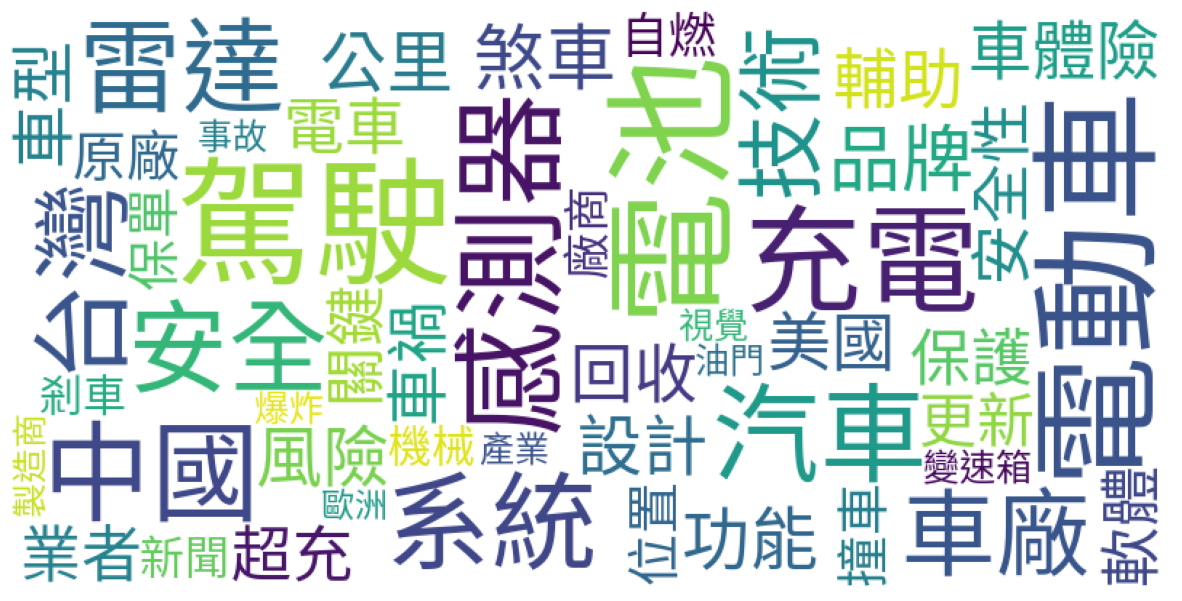

In [17]:
# 繪製文字雲
freq_experience_pos = get_freq_to_wordcloud(df_experience_pos)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =50)
wordcloud_nostop.generate_from_frequencies(freq_experience_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### 負面文字雲

Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/SMA_project/dict/dict.txt ...
2024-06-10 16:20:07,533 : DEBUG : Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uf992522de474b4d252da611e5422339f.cache
2024-06-10 16:20:07,535 : DEBUG : Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uf992522de474b4d252da611e5422339f.cache
Loading model cost 0.222 seconds.
2024-06-10 16:20:07,757 : DEBUG : Loading model cost 0.222 seconds.
Prefix dict has been built successfully.
2024-06-10 16:20:07,758 : DEBUG : Prefix dict has been built successfully.


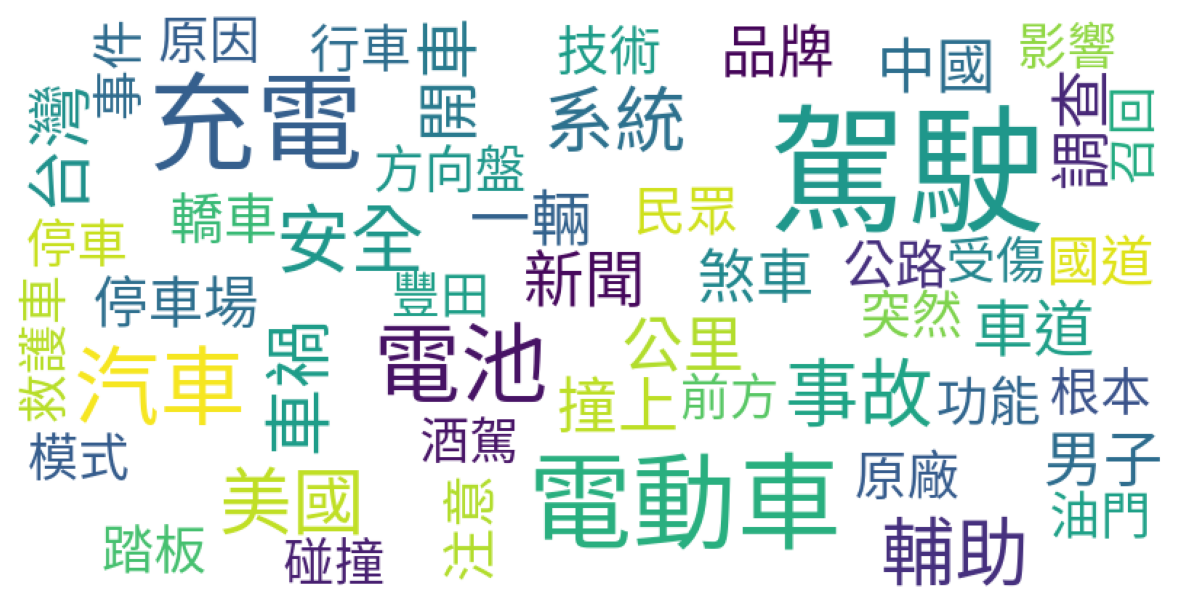

In [18]:
# 繪製文字雲
freq_experience_pos = get_freq_to_wordcloud(df_experience_neg)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =50)
wordcloud_nostop.generate_from_frequencies(freq_experience_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### Bigram

In [74]:
df_experience['artContent'] = df_experience['artContent'].astype(str)
# 只留下中文字
df_experience['sentence'] = df_experience['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_experience.head(5)

system_id              artDate            artTitle  \
2           2  2023-01-02 12:47:31    新聞開特斯拉滑手機被勸嗆網友有毛   
3           3  2023-01-02 18:01:04  討論是不是真的有些四輪覺得自己是大爺   
20         20  2023-01-07 16:47:05    問題特斯拉扯著是不是比較少改車啊   
24         24  2023-01-10 16:54:06        問題怎麼調適買錯車的心情   
25         25  2023-01-11 18:27:00       討論不看看外型就知道的品牌   

                                           artContent  \
2   原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3   如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
20  路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...   
24  人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...   
25  對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...   

                                             sentence  \
2   原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3   如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
20  路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...   
24  人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...   
25  對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...   

                                                  LLM sentiment  class  
2   {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗  
3                         {"文章分類":"使用者體驗","情緒":"負面",}        負面  使用者體驗  
20                      {"文章分類": "使用者體驗","情緒": "負面",}        負面  使用者體驗  
24                       {"文章分類": "使用者體驗","情緒": "負面"}        負面  使用者體驗  
25                      {"文章分類": "使用者體驗","情緒": "負面",}        負面  使用者體驗

In [75]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [76]:
exper_bigram = df_experience.copy()

exper_bigram["word"] = exper_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
exper_bigram = exper_bigram.explode('word')

exper_bigram.head(3)

system_id              artDate          artTitle  \
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   

                                          artContent  \
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                            sentence  \
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                                 LLM sentiment  class     word  
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗   王家 徐兆緯  
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗   徐兆緯 前電  
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗  前電 世界冠軍

In [77]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0     輔助 駕駛     39
1     網址 意見     24
2   意見 標點符號     24
3    汽車 製造商     19
4     續航 里程     16
5     充電 充電     15
6     里程 公里     15
7     後輪 驅動     14
8     充電 設備     14
9     駕駛 輔助     13
10    露營 模式     12
11    彩色 電子     12
12    里程 焦慮     12
13    駕駛 體驗     10
14    動能 回收     10
18    開車 開車      9
20    活動 網頁      9
19    油車 電車      9
17   行車 記錄器      9
16    輔助 系統      9


In [78]:
exper_trigram = df_experience.copy()

exper_trigram["word"] = exper_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
exper_trigram = exper_trigram.explode('word')

exper_trigram.head(3)

system_id              artDate          artTitle  \
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   

                                          artContent  \
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                            sentence  \
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                                 LLM sentiment  class  \
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗   
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗   
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗   

          word  
2    王家 徐兆緯 前電  
2  徐兆緯 前電 世界冠軍  
2   前電 世界冠軍 日前

Trigram

In [79]:
# 計算每個組合出現的次數
exper_trigram_count = exper_trigram['word'].value_counts().reset_index()

# 重命名列
exper_trigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_trigram_count_sorted = exper_trigram_count.sort_values('count', ascending=False).head(20)

print(exper_trigram_count_sorted)

          word  count
0   網址 意見 標點符號     24
1     駕駛 輔助 系統      7
2   座談會 車馬費 民國      6
3    車馬費 民國 年次      6
4     開車 開車 輔助      6
9     電量 公里 電耗      5
12    消耗 電量 公里      5
11    公里 消耗 電量      5
10    里程 公里 消耗      5
8    公里 電耗 每度電      5
7    電耗 每度電 里程      5
6    每度電 里程 公里      5
5   百周年 紀念 概念車      5
21    討論 熱烈 開來      4
28    實質 佔用 充電      4
27    輔助 駕駛 系統      4
26    一半 緩速 前進      4
25    雙方 對罵 糾紛      4
24    範圍 尋車 地點      4
23    日期 範圍 尋車      4


In [25]:
bigramudist = df_experience.copy()

bigramudist["word"] = bigramudist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramudist = bigramudist.explode('word')
bigramudist.dropna(subset = ['word'], axis=0, how='any', inplace=True)
bigramudist.head(3)


system_id              artDate           artTitle  \
6          6  2023-01-03 10:14:48  新聞美國汽車召回排名揭曉第一名超過   
6          6  2023-01-03 10:14:48  新聞美國汽車召回排名揭曉第一名超過   
6          6  2023-01-03 10:14:48  新聞美國汽車召回排名揭曉第一名超過   

                                          artContent  \
6  先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...   
6  先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...   
6  先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...   

                                            sentence  \
6  先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...   
6  先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...   
6  先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...   

                             LLM sentiment  class   word  
6  {"文章分類": "安全性方面","情緒": "中性",}        中性  安全性方面  先上 美國  
6  {"文章分類": "安全性方面","情緒": "中性",}        中性  安全性方面  美國 新聞  
6  {"文章分類": "安全性方面","情緒": "中性",}        中性  安全性方面  新聞 原圖

In [26]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0     輔助 駕駛     95
2   意見 標點符號     33
1     網址 意見     33
3     高速 公路     27
4     駕駛 系統     24
5     安全 接管     22
6     哨兵 模式     21
7    可靠度 評分     20
8    行車 記錄器     19
9     充電 充電     19
10   評分 可靠度     18
11    輔助 系統     17
15   全自動 駕駛     16
16    電池 自燃     16
13    充電 規格     16
14   中國 電動車     16
12    駕駛 輔助     16
17    汽車 品牌     15
18    駕駛 功能     15
19   電動車 充電     14


In [27]:
bigramudist['word'] = bigramudist['word'].astype(str)
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramudist = FreqDist(bigramudist['word'].apply(lambda x: tuple(x.split(' '))))
bigramudist.most_common(5)

[(('輔助', '駕駛'), 95),
 (('網址', '意見'), 33),
 (('意見', '標點符號'), 33),
 (('高速', '公路'), 27),
 (('駕駛', '系統'), 24)]

In [28]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramudist.most_common(50)}
d.items()

dict_items([(('輔助', '駕駛'), 95), (('網址', '意見'), 33), (('意見', '標點符號'), 33), (('高速', '公路'), 27), (('駕駛', '系統'), 24), (('安全', '接管'), 22), (('哨兵', '模式'), 21), (('可靠度', '評分'), 20), (('充電', '充電'), 19), (('行車', '記錄器'), 19), (('評分', '可靠度'), 18), (('輔助', '系統'), 17), (('全自動', '駕駛'), 16), (('駕駛', '輔助'), 16), (('中國', '電動車'), 16), (('充電', '規格'), 16), (('電池', '自燃'), 16), (('駕駛', '功能'), 15), (('汽車', '品牌'), 15), (('電動車', '充電'), 14), (('快速', '道路'), 14), (('電動車', '專屬'), 14), (('里程', '公里'), 14), (('幹預', '油門'), 14), (('交通', '事故'), 13), (('美國', '國家'), 13), (('交通安全', '管理局'), 13), (('呼吸', '心跳'), 13), (('安全', '駕駛'), 13), (('駕駛', '感測器'), 13), (('油門', '踏板'), 13), (('駕駛', '技術'), 12), (('公路', '交通安全'), 12), (('緊急', '煞車'), 12), (('電動', '汽車'), 12), (('電動車', '電池'), 12), (('附加', '條款'), 12), (('汽車', '製造商'), 11), (('國家', '公路'), 11), (('一輛', '白色'), 11), (('安全', '氣囊'), 11), (('不明', '原因'), 11), (('乙式', '車險'), 11), (('充電', '車格'), 11), (('駕駛', '軟體'), 10), (('電子', '手煞車'), 10), (('駕駛', '酒駕'), 10), (('車禍', '一輛'), 10), (('開啟', '輔

In [29]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    print(k[0])
    print(v)
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.1 for w in  G.edges(data=True)]

輔助
95
網址
33
意見
33
高速
27
駕駛
24
安全
22
哨兵
21
可靠度
20
充電
19
行車
19
評分
18
輔助
17
全自動
16
駕駛
16
中國
16
充電
16
電池
16
駕駛
15
汽車
15
電動車
14
快速
14
電動車
14
里程
14
幹預
14
交通
13
美國
13
交通安全
13
呼吸
13
安全
13
駕駛
13
油門
13
駕駛
12
公路
12
緊急
12
電動
12
電動車
12
附加
12
汽車
11
國家
11
一輛
11
安全
11
不明
11
乙式
11
充電
11
駕駛
10
電子
10
駕駛
10
車禍
10
開啟
10
毫米
10


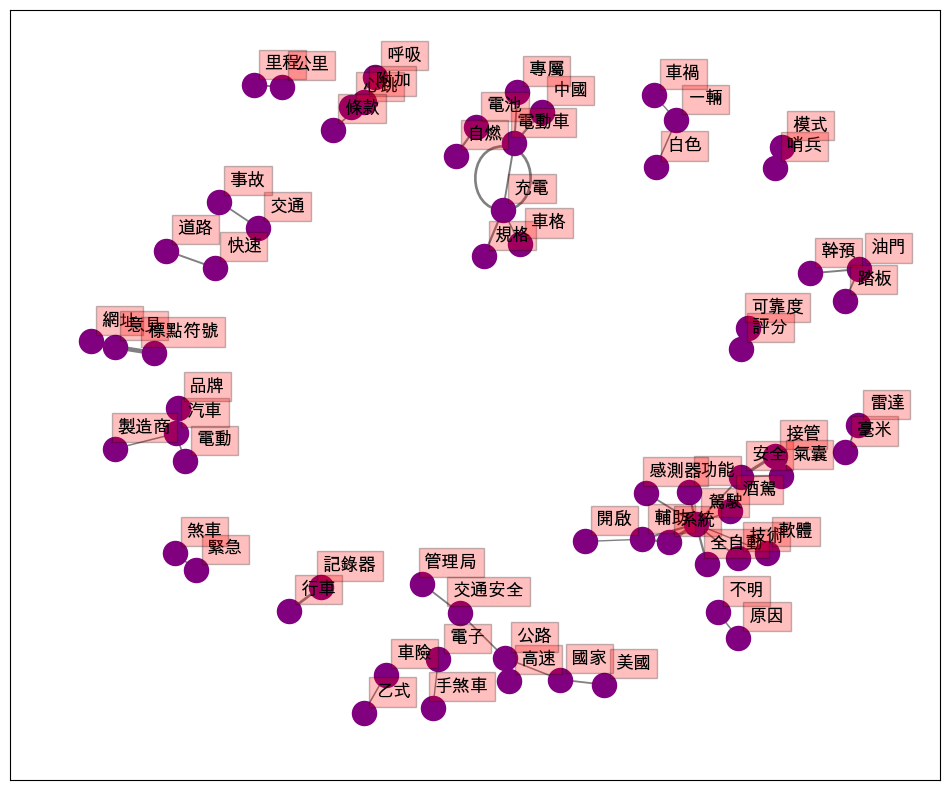

In [30]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=0.5)# k越大，斥力越小l;k越小，斥力越大

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.show()

## 性價比方面深入分析

##### 在性價比方面，透過LLM分出的結果以查看其所分出的正負面相關多字詞

In [95]:
df = pd.read_csv("data/ppt_tesla_classified_cleaned.csv")
df.dropna(subset = ['sentence'], axis=0, how='any', inplace=True)
df_experience = df[df["class"]== "性價比方面"]
df_experience_pos =df_experience[df_experience['sentiment']=='正面']
df_experience_neg =df_experience[df_experience['sentiment']=='負面']
df_experience

system_id              artDate           artTitle  \
0             0  2023-01-01 10:48:19       情報慟特斯拉二手價跌好多   
1             1  2023-01-01 22:42:25        問題特斯拉久了會掉電嗎   
4             4  2023-01-02 19:21:24  新聞美國汽車召回排名揭曉第一名超過   
7             7  2023-01-03 12:31:28   新聞又是破紀錄的一年特斯拉年交車   
10           10  2023-01-04 10:00:54  新聞和泰汽車連續年稱霸台灣車市銷售   
...         ...                  ...                ...   
1574       1574  2024-04-29 11:50:48          討論這感覺已經不對   
1579       1579  2024-04-30 10:33:28   新聞特斯拉全新入門電動車準備量產   
1580       1580  2024-04-30 10:33:35   新聞特斯拉全新入門電動車準備量產   
1583       1583  2024-04-30 19:19:58                 問題   
1584       1584  2024-04-30 19:53:28                 問題   

                                             artContent  \
0                         八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1     各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
4     原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
7     原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...   
10    笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...   
...                                                 ...   
1574  之前特斯拉傳要推出平價車我本來要買看到這個消息想說等看看特斯拉出的平價車因為我對於內裝性能外...   
1579  智借社團圖片一用看起來按照特斯拉的定價模式大概就是產地價乘上倍稅金所以萬美元到台灣應該不到萬...   
1580  哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...   
1583  最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...   
1584  吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...   

                                               sentence  \
0                         八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1     各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
4     原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
7     原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...   
10    笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...   
...                                                 ...   
1574  之前特斯拉傳要推出平價車我本來要買看到這個消息想說等看看特斯拉出的平價車因為我對於內裝性能外...   
1579  智借社團圖片一用看起來按照特斯拉的定價模式大概就是產地價乘上倍稅金所以萬美元到台灣應該不到萬...   
1580  哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...   
1583  最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...   
1584  吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...   

                                LLM sentiment  class  
0     {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面  
1       {"文章分類":"性價比方面","情緒":"負面",}        負面  性價比方面  
4     {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面  
7      {"文章分類": "性價比方面","情緒": "正面"}        正面  性價比方面  
10    {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面  
...                             ...       ...    ...  
1574  {"文章分類": "性價比方面","情緒": "積極",}        積極  性價比方面  
1579  {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面  
1580  {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面  
1583  {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面  
1584  {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面  

[568 rows x 8 columns]

In [96]:
df_experience_neg

system_id              artDate           artTitle  \
1             1  2023-01-01 22:42:25        問題特斯拉久了會掉電嗎   
4             4  2023-01-02 19:21:24  新聞美國汽車召回排名揭曉第一名超過   
10           10  2023-01-04 10:00:54  新聞和泰汽車連續年稱霸台灣車市銷售   
12           12  2023-01-04 11:44:35  新聞特斯拉誇大續航力南韓裁罰億韓元   
15           15  2023-01-06 17:08:33     新聞特斯拉跳水大降價台灣大陸   
...         ...                  ...                ...   
1563       1563  2024-04-26 13:26:47          電車台灣特斯拉降價   
1565       1565  2024-04-26 15:32:35      討論降到多少可以血洗市場啊   
1570       1570  2024-04-27 14:49:57      新聞中國燃油車佔比首次跌破   
1583       1583  2024-04-30 19:19:58                 問題   
1584       1584  2024-04-30 19:53:28                 問題   

                                             artContent  \
1     各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
4     原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
10    笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...   
12    特斯拉誇大續航力南韓裁罰億韓元原文連結原文內容自由時報編譯魏國金綜合報導南韓反壟斷監管機關公...   
15    沒讀過經濟學是不是亞當史密斯說過有一雙看不見的手供給需求來平衡市場今天消費者覺得太貴自然不會...   
...                                                 ...   
1563  可惜台灣沒有強的國產電車廠關稅保護保護這麼多年結果就是扶不起的阿斗弄成現在台灣人買進口車超貴...   
1565  還沒降價前已經一夫當關幹掉了如果降到萬原本在考慮的應該會有不少人跳船估計進口車只有能賣贏了年...   
1570  原文連結原文內容根據中國全國乘聯會最新公佈的數據今年月到日為止的市場零售銷量為萬輛批發銷量則...   
1583  最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...   
1584  吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...   

                                               sentence  \
1     各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
4     原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
10    笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...   
12    特斯拉誇大續航力南韓裁罰億韓元原文連結原文內容自由時報編譯魏國金綜合報導南韓反壟斷監管機關公...   
15    沒讀過經濟學是不是亞當史密斯說過有一雙看不見的手供給需求來平衡市場今天消費者覺得太貴自然不會...   
...                                                 ...   
1563  可惜台灣沒有強的國產電車廠關稅保護保護這麼多年結果就是扶不起的阿斗弄成現在台灣人買進車超貴的...   
1565  還沒降價前已經一夫當關幹掉了如果降到萬原本在考慮的應該會有不少人跳船估計進車只有能賣贏了年度...   
1570  原文連結原文內容根據中國全國乘聯會最新公佈的數據今年月到日為止的市場零售銷量為萬輛批發銷量則...   
1583  最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...   
1584  吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...   

                                LLM sentiment  class  
1       {"文章分類":"性價比方面","情緒":"負面",}        負面  性價比方面  
4     {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面  
10    {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面  
12    {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面  
15     {"文章分類": "性價比方面","情緒": "負面"}        負面  性價比方面  
...                             ...       ...    ...  
1563  {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面  
1565    {"文章分類":"性價比方面","情緒":"負面",}        負面  性價比方面  
1570   {"文章分類": "性價比方面","情緒": "負面"}        負面  性價比方面  
1583  {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面  
1584  {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面  

[402 rows x 8 columns]

In [97]:
def get_freq_to_wordcloud(input_df):
    jieba.set_dictionary("dict/dict.txt")
    df_experience_pos＿word = input_df.assign(word = input_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
    df_experience_pos＿word = df_experience_pos＿word.loc[df_experience_pos＿word['word'].str.len() > 1]
    stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
    after_clear_df_pos = df_experience_pos＿word[~df_experience_pos＿word['word'].isin(stopwords)]
    freq_df_clear_pos = pd.DataFrame(pd.value_counts(after_clear_df_pos['word'])).sort_values(by = ['count'], ascending = False).reset_index()
    freq_dict_nostop_pos = freq_df_clear_pos.set_index('word').to_dict()
    freq_dict_nostop_pos = freq_dict_nostop_pos['count']
    return freq_dict_nostop_pos


### 正面文字雲

Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/SMA_project/dict/dict.txt ...
2024-06-10 16:31:50,761 : DEBUG : Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uf992522de474b4d252da611e5422339f.cache
2024-06-10 16:31:50,762 : DEBUG : Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uf992522de474b4d252da611e5422339f.cache
Loading model cost 0.231 seconds.
2024-06-10 16:31:50,993 : DEBUG : Loading model cost 0.231 seconds.
Prefix dict has been built successfully.
2024-06-10 16:31:50,994 : DEBUG : Prefix dict has been built successfully.


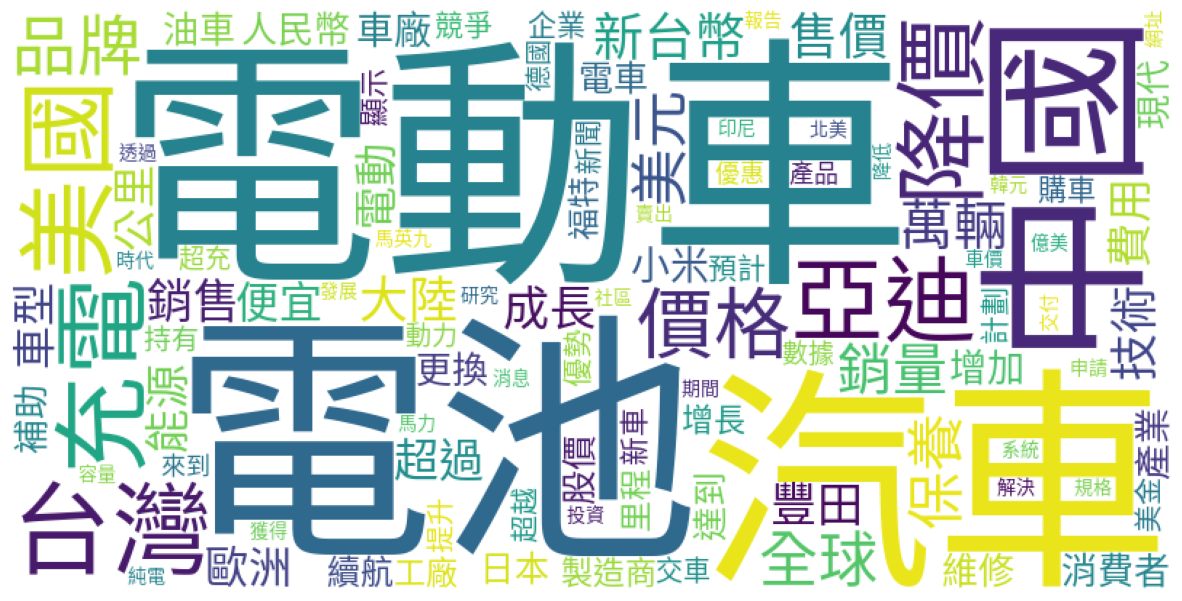

In [98]:
# 繪製文字雲
freq_experience_pos = get_freq_to_wordcloud(df_experience_pos)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_experience_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### 負面文字雲

Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/SMA_project/dict/dict.txt ...
2024-06-10 16:31:52,290 : DEBUG : Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uf992522de474b4d252da611e5422339f.cache
2024-06-10 16:31:52,291 : DEBUG : Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uf992522de474b4d252da611e5422339f.cache
Loading model cost 0.212 seconds.
2024-06-10 16:31:52,503 : DEBUG : Loading model cost 0.212 seconds.
Prefix dict has been built successfully.
2024-06-10 16:31:52,504 : DEBUG : Prefix dict has been built successfully.


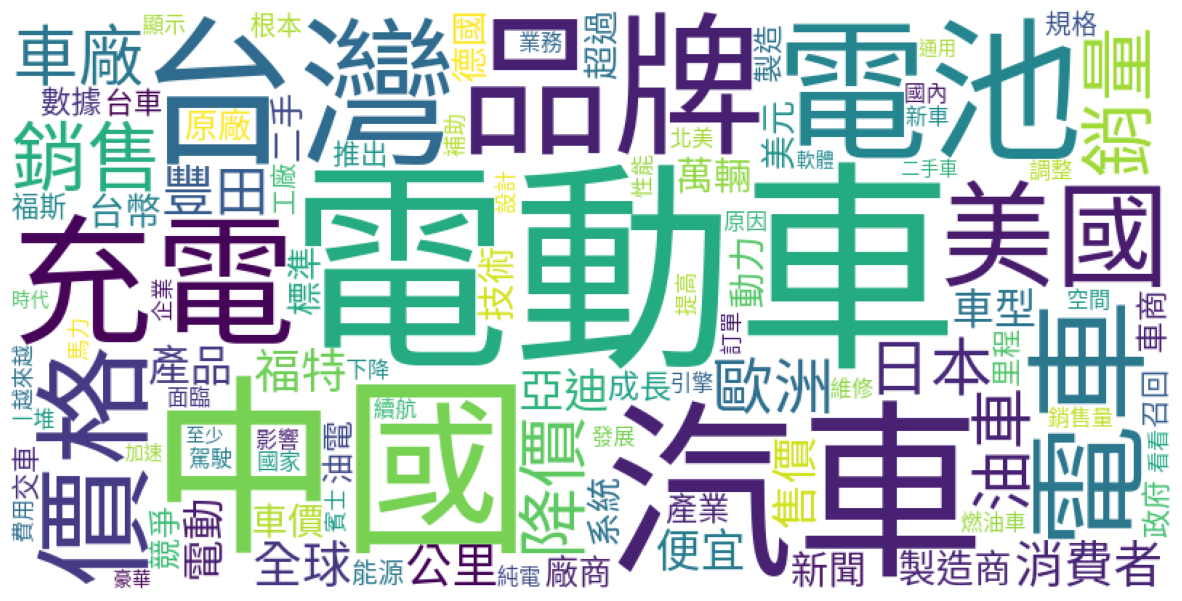

In [99]:
# 繪製文字雲
freq_experience_pos = get_freq_to_wordcloud(df_experience_neg)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_experience_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### Bigram

In [100]:
df_experience['artContent'] = df_experience['artContent'].astype(str)
# 只留下中文字
df_experience['sentence'] = df_experience['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_experience.head(5)

system_id              artDate           artTitle  \
0           0  2023-01-01 10:48:19       情報慟特斯拉二手價跌好多   
1           1  2023-01-01 22:42:25        問題特斯拉久了會掉電嗎   
4           4  2023-01-02 19:21:24  新聞美國汽車召回排名揭曉第一名超過   
7           7  2023-01-03 12:31:28   新聞又是破紀錄的一年特斯拉年交車   
10         10  2023-01-04 10:00:54  新聞和泰汽車連續年稱霸台灣車市銷售   

                                           artContent  \
0                       八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1   各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
4   原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
7   原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...   
10  笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...   

                                             sentence  \
0                       八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1   各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
4   原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...   
7   原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...   
10  笑死這種在中國月銷售排行第名的車來到台灣被捧成神代表台灣韭菜真的很好割以下資料來自車主之家銷...   

                              LLM sentiment  class  
0   {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面  
1     {"文章分類":"性價比方面","情緒":"負面",}        負面  性價比方面  
4   {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面  
7    {"文章分類": "性價比方面","情緒": "正面"}        正面  性價比方面  
10  {"文章分類": "性價比方面","情緒": "負面",}        負面  性價比方面

In [101]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [102]:
exper_bigram = df_experience.copy()

exper_bigram["word"] = exper_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
exper_bigram = exper_bigram.explode('word')

exper_bigram.head(3)

system_id              artDate      artTitle  \
0          0  2023-01-01 10:48:19  情報慟特斯拉二手價跌好多   
0          0  2023-01-01 10:48:19  情報慟特斯拉二手價跌好多   
0          0  2023-01-01 10:48:19  情報慟特斯拉二手價跌好多   

                      artContent                       sentence  \
0  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
0  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
0  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   

                             LLM sentiment  class    word  
0  {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面   八卦 官網  
0  {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面  官網 二手車  
0  {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面  二手車 三方

In [103]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0    汽車 製造商     62
1     中國 汽車     48
2     中國 品牌     45
3    電動車 電池     42
4     汽車 中國     39
5     網址 意見     39
6   意見 標點符號     39
7    中國 電動車     39
8    電動車 銷量     36
9     電動 汽車     34
10   電動車 銷售     31
11    寧德 時代     31
12    續航 里程     30
13    汽車 品牌     26
14    豪華 品牌     26
15    保養 費用     26
16    通用 汽車     25
17   全球 電動車     25
18   電動車 品牌     25
19   美國 電動車     25


In [104]:
exper_trigram = df_experience.copy()

exper_trigram["word"] = exper_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
exper_trigram = exper_trigram.explode('word')

exper_trigram.head(3)

system_id              artDate      artTitle  \
0          0  2023-01-01 10:48:19  情報慟特斯拉二手價跌好多   
0          0  2023-01-01 10:48:19  情報慟特斯拉二手價跌好多   
0          0  2023-01-01 10:48:19  情報慟特斯拉二手價跌好多   

                      artContent                       sentence  \
0  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
0  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
0  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   

                             LLM sentiment  class       word  
0  {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面  八卦 官網 二手車  
0  {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面  官網 二手車 三方  
0  {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面  二手車 三方 平台

Trigram

In [105]:
# 計算每個組合出現的次數
exper_trigram_count = exper_trigram['word'].value_counts().reset_index()

# 重命名列
exper_trigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_trigram_count_sorted = exper_trigram_count.sort_values('count', ascending=False).head(20)

print(exper_trigram_count_sorted)

          word  count
0   網址 意見 標點符號     39
1     北美 充電 標準     14
2     看板 標題 新聞     12
3     銷量 累計 銷量     12
4     累計 銷量 累計     12
5     召回 召回 總數     11
6    美金 元約 新台幣     10
7     總數 召回 召回      9
8   百分比 適用 百分比      9
9     中國 汽車 出口      9
10   適用 百分比 適用      9
11    召回 總數 召回      9
13    萬輛 萬輛 萬輛      8
12    作者 看板 標題      8
14    售價 美金 元約      7
15   中華 共和國 品牌      7
16    公里 續航 里程      7
24  售價 人民幣 新台幣      6
30    對台 導彈 形狀      6
29    中共 對台 導彈      6


In [106]:
bigramudist = df_experience.copy()

bigramudist["word"] = bigramudist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramudist = bigramudist.explode('word')
bigramudist.dropna(subset = ['word'], axis=0, how='any', inplace=True)
bigramudist.head(3)


system_id              artDate      artTitle  \
0          0  2023-01-01 10:48:19  情報慟特斯拉二手價跌好多   
0          0  2023-01-01 10:48:19  情報慟特斯拉二手價跌好多   
0          0  2023-01-01 10:48:19  情報慟特斯拉二手價跌好多   

                      artContent                       sentence  \
0  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
0  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
0  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎  八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   

                             LLM sentiment  class    word  
0  {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面   八卦 官網  
0  {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面  官網 二手車  
0  {"文章分類": "性價比方面","情緒": "正面",}        正面  性價比方面  二手車 三方

In [107]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0    汽車 製造商     62
1     中國 汽車     48
2     中國 品牌     45
3    電動車 電池     42
4     汽車 中國     39
5     網址 意見     39
6   意見 標點符號     39
7    中國 電動車     39
8    電動車 銷量     36
9     電動 汽車     34
10   電動車 銷售     31
11    寧德 時代     31
12    續航 里程     30
13    汽車 品牌     26
14    豪華 品牌     26
15    保養 費用     26
16    通用 汽車     25
17   全球 電動車     25
18   電動車 品牌     25
19   美國 電動車     25


In [108]:
bigramudist['word'] = bigramudist['word'].astype(str)
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramudist = FreqDist(bigramudist['word'].apply(lambda x: tuple(x.split(' '))))
bigramudist.most_common(5)

[(('汽車', '製造商'), 62),
 (('中國', '汽車'), 48),
 (('中國', '品牌'), 45),
 (('電動車', '電池'), 42),
 (('網址', '意見'), 39)]

In [109]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramudist.most_common(50)}
d.items()

dict_items([(('汽車', '製造商'), 62), (('中國', '汽車'), 48), (('中國', '品牌'), 45), (('電動車', '電池'), 42), (('網址', '意見'), 39), (('意見', '標點符號'), 39), (('汽車', '中國'), 39), (('中國', '電動車'), 39), (('電動車', '銷量'), 36), (('電動', '汽車'), 34), (('電動車', '銷售'), 31), (('寧德', '時代'), 31), (('續航', '里程'), 30), (('汽車', '品牌'), 26), (('豪華', '品牌'), 26), (('保養', '費用'), 26), (('美國', '電動車'), 25), (('電動車', '品牌'), 25), (('汽車', '廠商'), 25), (('通用', '汽車'), 25), (('全球', '電動車'), 25), (('消費者', '報告'), 25), (('美元', '台幣'), 23), (('福斯', '汽車'), 23), (('動力', '電池'), 23), (('充電', '規格'), 23), (('充電', '標準'), 23), (('現代', '汽車'), 22), (('競爭', '對手'), 22), (('人民幣', '新台幣'), 21), (('累計', '銷量'), 21), (('二手', '車商'), 21), (('全球', '汽車'), 21), (('電池', '容量'), 20), (('電動車', '充電'), 19), (('汽車', '產業'), 19), (('電池', '製造商'), 19), (('能源', '汽車'), 18), (('汽車', '出口'), 18), (('電池', '工廠'), 18), (('北美', '充電'), 18), (('電池', '技術'), 17), (('充電', '網路'), 17), (('油電', '混合'), 16), (('取消', '訂單'), 16), (('汽車', '銷量'), 16), (('電池', '更換'), 16), (('中國', '大陸'), 15), (('數據', '顯示')

In [110]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    print(k[0])
    print(v)
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.1 for w in  G.edges(data=True)]

汽車
62
中國
48
中國
45
電動車
42
網址
39
意見
39
汽車
39
中國
39
電動車
36
電動
34
電動車
31
寧德
31
續航
30
汽車
26
豪華
26
保養
26
美國
25
電動車
25
汽車
25
通用
25
全球
25
消費者
25
美元
23
福斯
23
動力
23
充電
23
充電
23
現代
22
競爭
22
人民幣
21
累計
21
二手
21
全球
21
電池
20
電動車
19
汽車
19
電池
19
能源
18
汽車
18
電池
18
北美
18
電池
17
充電
17
油電
16
取消
16
汽車
16
電池
16
中國
15
數據
15
看板
15


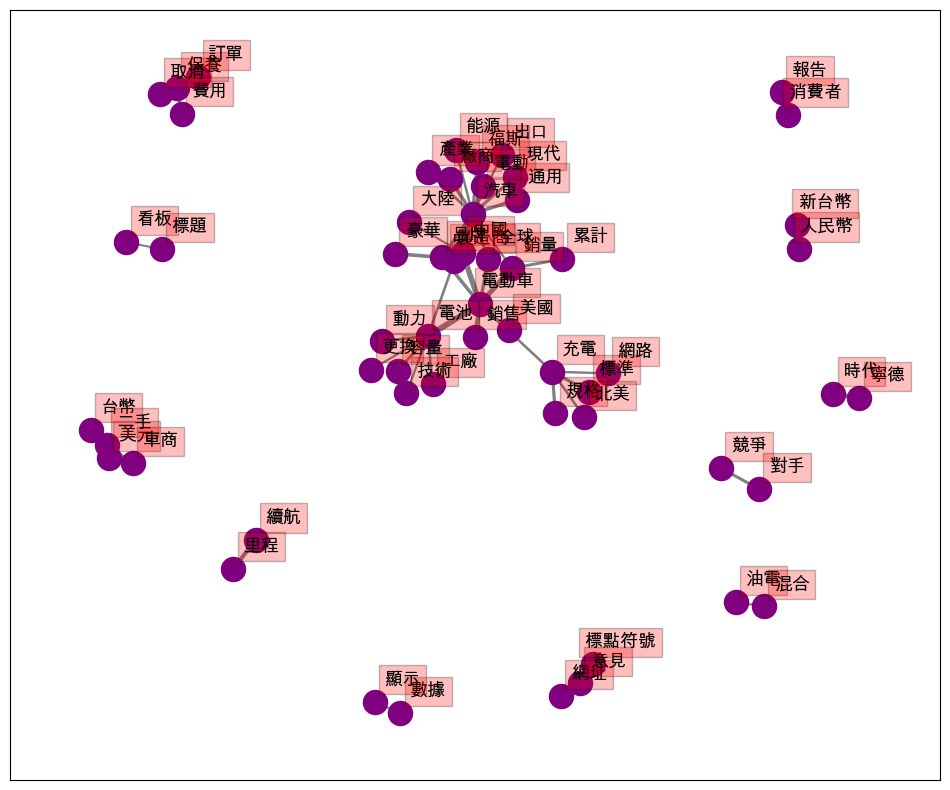

In [111]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=0.5)# k越大，斥力越小l;k越小，斥力越大

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.show()

## 使用者體驗面深入分析

##### 在使用者體驗方面，透過LLM分出的結果以查看其所分出的正負面相關多字詞

In [93]:
df = pd.read_csv("data/ppt_tesla_classified_cleaned.csv")
df_experience = df[df["class"]== "使用者體驗"]
df_experience_pos =df_experience[df_experience['sentiment']=='正面']
df_experience_neg =df_experience[df_experience['sentiment']=='負面']
df_experience

system_id              artDate             artTitle  \
2             2  2023-01-02 12:47:31     新聞開特斯拉滑手機被勸嗆網友有毛   
3             3  2023-01-02 18:01:04   討論是不是真的有些四輪覺得自己是大爺   
20           20  2023-01-07 16:47:05     問題特斯拉扯著是不是比較少改車啊   
24           24  2023-01-10 16:54:06         問題怎麼調適買錯車的心情   
25           25  2023-01-11 18:27:00        討論不看看外型就知道的品牌   
...         ...                  ...                  ...   
1569       1569  2024-04-26 22:02:33  新聞突破中國低價競爭特斯拉正走入重新調   
1571       1571  2024-04-28 02:40:00        電車特斯拉改款後座有螢幕萬   
1575       1575  2024-04-29 12:31:50         心得特斯拉煥新版試駕心得   
1576       1576  2024-04-29 17:57:25          電車拖吊時哨兵模式運作   
1582       1582  2024-04-30 17:45:19  新聞銷售降溫賓士上季獲利銳減逾三成福斯   

                                             artContent  \
2     原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3     如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
20    路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...   
24    人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...   
25    對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...   
...                                                 ...   
1569  補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...   
1571  昨天去試乘順便看改款的業務有傳簡訊不過新版沒有試乘車第一次開他的方向盤很簡潔我喜歡現在的車做...   
1575  完整圖文這次試駕的是全輪驅動版有選配烈焰紅車漆吋輪圈輪胎尺寸搭配的原廠胎是馬牌靜音型輪胎車尾...   
1576  剛看到一台被拖吊大燈在那邊閃這個情況的哨兵模式是會持續地一直運作像是直播那樣還是周期性的一直...   
1582  都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...   

                                               sentence  \
2     原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3     如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
20    路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...   
24    人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...   
25    對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...   
...                                                 ...   
1569  補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...   
1571  昨天去試乘順便看改款的業務有傳簡訊不過新版沒有試乘車第一次開他的方向盤很簡潔我喜歡現在的車做...   
1575  完整圖文這次試駕的是全輪驅動版有選配烈焰紅車漆吋輪圈輪胎尺寸搭配的原廠胎是馬牌靜音型輪胎車尾...   
1576  剛看到一台被拖吊大燈在那邊閃這個情況的哨兵模式是會持續地一直運作像是直播那樣還是周期性的一直...   
1582  都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...   

                                                    LLM sentiment  class  
2     {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗  
3                           {"文章分類":"使用者體驗","情緒":"負面",}        負面  使用者體驗  
20                        {"文章分類": "使用者體驗","情緒": "負面",}        負面  使用者體驗  
24                         {"文章分類": "使用者體驗","情緒": "負面"}        負面  使用者體驗  
25                        {"文章分類": "使用者體驗","情緒": "負面",}        負面  使用者體驗  
...                                                 ...       ...    ...  
1569                       {"文章分類": "使用者體驗","情緒": "負面"}        負面  使用者體驗  
1571                   {  "文章分類": "使用者體驗",  "情緒": "正面"}        正面  使用者體驗  
1575  {"文章分類": "使用者體驗","情緒": "正面","內容": "煥新版方向盤握感比舊款...        正面  使用者體驗  
1576                        {"文章分類":"使用者體驗","情緒":"負面",}        負面  使用者體驗  
1582                       {"文章分類": "使用者體驗","情緒": "正面"}        正面  使用者體驗  

[448 rows x 8 columns]

In [94]:
df_experience_neg

system_id              artDate             artTitle  \
2             2  2023-01-02 12:47:31     新聞開特斯拉滑手機被勸嗆網友有毛   
3             3  2023-01-02 18:01:04   討論是不是真的有些四輪覺得自己是大爺   
20           20  2023-01-07 16:47:05     問題特斯拉扯著是不是比較少改車啊   
24           24  2023-01-10 16:54:06         問題怎麼調適買錯車的心情   
25           25  2023-01-11 18:27:00        討論不看看外型就知道的品牌   
...         ...                  ...                  ...   
1534       1534  2024-04-20 21:55:03   討論二手兩百多萬舒適省油空間大的轎車   
1542       1542  2024-04-22 11:14:13            問題特斯拉業務很急   
1559       1559  2024-04-26 09:08:39            電車台灣特斯拉降價   
1569       1569  2024-04-26 22:02:33  新聞突破中國低價競爭特斯拉正走入重新調   
1576       1576  2024-04-29 17:57:25          電車拖吊時哨兵模式運作   

                                             artContent  \
2     原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3     如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
20    路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...   
24    人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...   
25    對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...   
...                                                 ...   
1534  如題去年二月買了空間大的沒話說但舒適性油耗就差強人意原先預計一年大概三萬公里油耗每公升公里還...   
1542  之前聽別人說特斯拉業務不是很在乎業績因為都是在網路上付下訂為什麼我遇到的業務很急看個煥新版一...   
1559         特斯拉出現錯誤台灣版誤植趕快爆買特斯拉現買現賺萬大家可以看看是網頁錯誤還是整個都錯誤   
1569  補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...   
1576  剛看到一台被拖吊大燈在那邊閃這個情況的哨兵模式是會持續地一直運作像是直播那樣還是周期性的一直...   

                                               sentence  \
2     原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3     如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
20    路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...   
24    人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...   
25    對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...   
...                                                 ...   
1534  如題去年二月買了空間大的沒話說但舒適性油耗就差強人意原先預計一年大概三萬公里油耗每公升公里還...   
1542  之前聽別人說特斯拉業務不是很在乎業績因為都是在網路上付下訂為什麼我遇到的業務很急看個煥新版一...   
1559         特斯拉出現錯誤台灣版誤植趕快爆買特斯拉現買現賺萬大家可以看看是網頁錯誤還是整個都錯誤   
1569  補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...   
1576  剛看到一台被拖吊大燈在那邊閃這個情況的哨兵模式是會持續地一直運作像是直播那樣還是周期性的一直...   

                                                    LLM sentiment  class  
2     {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗  
3                           {"文章分類":"使用者體驗","情緒":"負面",}        負面  使用者體驗  
20                        {"文章分類": "使用者體驗","情緒": "負面",}        負面  使用者體驗  
24                         {"文章分類": "使用者體驗","情緒": "負面"}        負面  使用者體驗  
25                        {"文章分類": "使用者體驗","情緒": "負面",}        負面  使用者體驗  
...                                                 ...       ...    ...  
1534  {"文章分類": "使用者體驗","情緒": "負面","內容": "空間大但舒適性油耗差，...        負面  使用者體驗  
1542                       {"文章分類": "使用者體驗","情緒": "負面"}        負面  使用者體驗  
1559                       {"文章分類": "使用者體驗","情緒": "負面"}        負面  使用者體驗  
1569                       {"文章分類": "使用者體驗","情緒": "負面"}        負面  使用者體驗  
1576                        {"文章分類":"使用者體驗","情緒":"負面",}        負面  使用者體驗  

[163 rows x 8 columns]

In [95]:
def get_freq_to_wordcloud(input_df):
    jieba.set_dictionary("dict/dict.txt")
    df_experience_pos＿word = input_df.assign(word = input_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
    df_experience_pos＿word = df_experience_pos＿word.loc[df_experience_pos＿word['word'].str.len() > 1]
    stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
    after_clear_df_pos = df_experience_pos＿word[~df_experience_pos＿word['word'].isin(stopwords)]
    freq_df_clear_pos = pd.DataFrame(pd.value_counts(after_clear_df_pos['word'])).sort_values(by = ['count'], ascending = False).reset_index()
    freq_dict_nostop_pos = freq_df_clear_pos.set_index('word').to_dict()
    freq_dict_nostop_pos = freq_dict_nostop_pos['count']
    return freq_dict_nostop_pos


### 正面文字雲

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
2024-06-10 18:02:02,973 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
2024-06-10 18:02:02,973 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
Loading model cost 0.230 seconds.
2024-06-10 18:02:03,203 : DEBUG : Loading model cost 0.230 seconds.
Prefix dict has been built successfully.
2024-06-10 18:02:03,204 : DEBUG : Prefix dict has been built successfully.


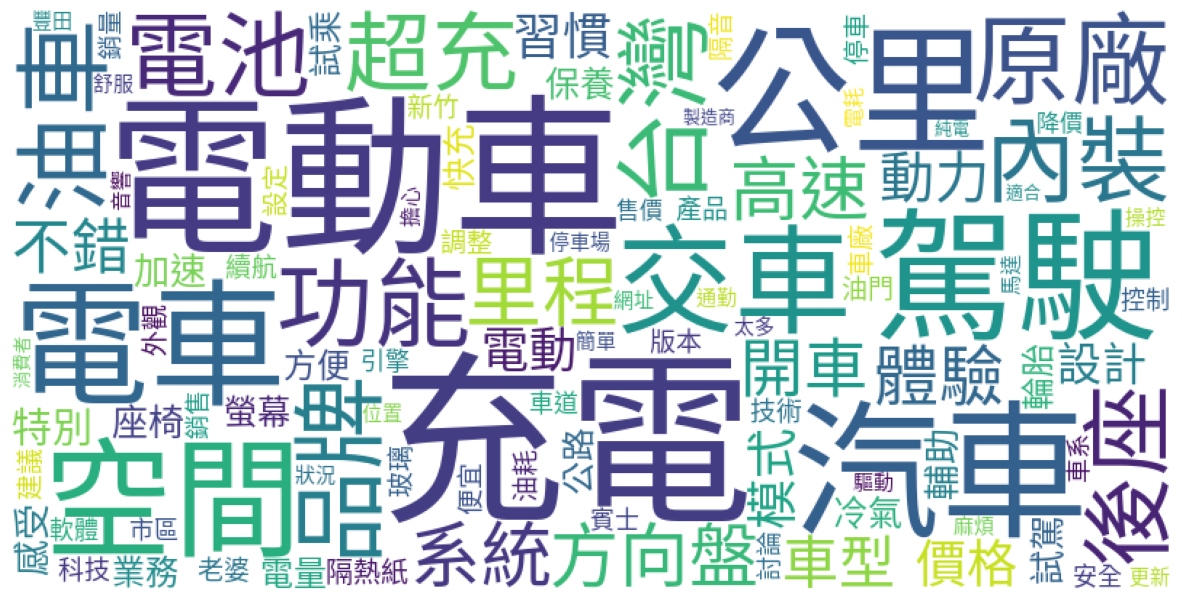

In [96]:
# 繪製文字雲
freq_experience_pos = get_freq_to_wordcloud(df_experience_pos)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_experience_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### 負面文字雲

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
2024-06-10 18:02:04,014 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
2024-06-10 18:02:04,015 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
Loading model cost 0.242 seconds.
2024-06-10 18:02:04,257 : DEBUG : Loading model cost 0.242 seconds.
Prefix dict has been built successfully.
2024-06-10 18:02:04,257 : DEBUG : Prefix dict has been built successfully.


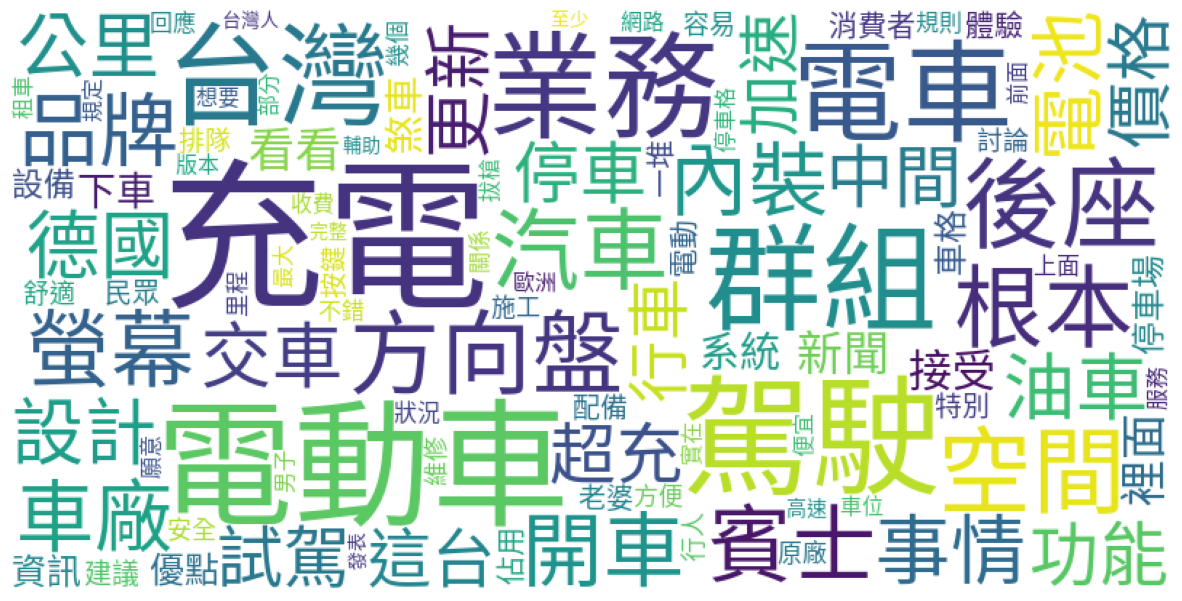

In [97]:
# 繪製文字雲
freq_experience_pos = get_freq_to_wordcloud(df_experience_neg)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_experience_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### Bigram

In [98]:
df_experience['artContent'] = df_experience['artContent'].astype(str)
# 只留下中文字
df_experience['sentence'] = df_experience['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_experience.head(5)

system_id              artDate            artTitle  \
2           2  2023-01-02 12:47:31    新聞開特斯拉滑手機被勸嗆網友有毛   
3           3  2023-01-02 18:01:04  討論是不是真的有些四輪覺得自己是大爺   
20         20  2023-01-07 16:47:05    問題特斯拉扯著是不是比較少改車啊   
24         24  2023-01-10 16:54:06        問題怎麼調適買錯車的心情   
25         25  2023-01-11 18:27:00       討論不看看外型就知道的品牌   

                                           artContent  \
2   原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3   如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
20  路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...   
24  人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...   
25  對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...   

                                             sentence  \
2   原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
3   如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...   
20  路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...   
24  人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...   
25  對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...   

                                                  LLM sentiment  class  
2   {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗  
3                         {"文章分類":"使用者體驗","情緒":"負面",}        負面  使用者體驗  
20                      {"文章分類": "使用者體驗","情緒": "負面",}        負面  使用者體驗  
24                       {"文章分類": "使用者體驗","情緒": "負面"}        負面  使用者體驗  
25                      {"文章分類": "使用者體驗","情緒": "負面",}        負面  使用者體驗

In [99]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [100]:
exper_bigram = df_experience.copy()

exper_bigram["word"] = exper_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
exper_bigram = exper_bigram.explode('word')

exper_bigram.head(3)

system_id              artDate          artTitle  \
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   

                                          artContent  \
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                            sentence  \
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                                 LLM sentiment  class    word  
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗  王家 徐兆緯  
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗  徐兆緯 電競  
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗   電競 世界

In [101]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0     高速 公路     43
1     輔助 駕駛     39
2   意見 標點符號     24
3     網址 意見     24
4    汽車 製造商     20
5     里程 公里     16
6     續航 里程     16
7     電動 汽車     15
8     充電 充電     15
9     後輪 驅動     14
10    充電 設備     14
11    駕駛 輔助     13
13    露營 模式     12
14    里程 焦慮     12
12   彩色 電子紙     12
15    內裝 質感     11
16    駕駛 體驗     10
17    完整 新聞     10
18    置物 空間     10
19    動能 回收     10


In [102]:
exper_trigram = df_experience.copy()

exper_trigram["word"] = exper_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
exper_trigram = exper_trigram.explode('word')

exper_trigram.head(3)

system_id              artDate          artTitle  \
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   

                                          artContent  \
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                            sentence  \
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                                 LLM sentiment  class  \
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗   
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗   
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗   

        word  
2  王家 徐兆緯 電競  
2  徐兆緯 電競 世界  
2   電競 世界 冠軍

Trigram

In [103]:
# 計算每個組合出現的次數
exper_trigram_count = exper_trigram['word'].value_counts().reset_index()

# 重命名列
exper_trigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_trigram_count_sorted = exper_trigram_count.sort_values('count', ascending=False).head(20)

print(exper_trigram_count_sorted)

          word  count
0   網址 意見 標點符號     24
1     駕駛 輔助 系統      7
2   座談會 車馬費 民國      6
3    車馬費 民國 男女      6
4     開車 開車 輔助      6
10   公里 電耗 每度電      5
14    里程 公里 消耗      5
12   每度電 里程 公里      5
11   電耗 每度電 里程      5
13   周年 紀念 概念車      5
9     電量 公里 電耗      5
8     消耗 電量 公里      5
7     公里 消耗 電量      5
6     作者 看板 標題      5
5     利曼 周年 紀念      5
27    單月 銷量 落在      4
38  地點 台北市 中山區      4
37    輔助 駕駛 系統      4
36    煥新 後輪 驅動      4
34    實質 佔用 充電      4


In [104]:
bigramudist = df_experience.copy()

bigramudist["word"] = bigramudist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramudist = bigramudist.explode('word')
bigramudist.dropna(subset = ['word'], axis=0, how='any', inplace=True)
bigramudist.head(3)


system_id              artDate          artTitle  \
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   
2          2  2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   

                                          artContent  \
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                            sentence  \
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                                 LLM sentiment  class    word  
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗  王家 徐兆緯  
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗  徐兆緯 電競  
2  {  "文章分類": "使用者體驗",  "情緒": "負面",  "詳細分類": {"服務...        負面  使用者體驗   電競 世界

In [105]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0     高速 公路     43
1     輔助 駕駛     39
2   意見 標點符號     24
3     網址 意見     24
4    汽車 製造商     20
5     里程 公里     16
6     續航 里程     16
7     電動 汽車     15
8     充電 充電     15
9     後輪 驅動     14
10    充電 設備     14
11    駕駛 輔助     13
13    露營 模式     12
14    里程 焦慮     12
12   彩色 電子紙     12
15    內裝 質感     11
16    駕駛 體驗     10
17    完整 新聞     10
18    置物 空間     10
19    動能 回收     10


In [106]:
bigramudist['word'] = bigramudist['word'].astype(str)
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramudist = FreqDist(bigramudist['word'].apply(lambda x: tuple(x.split(' '))))
bigramudist.most_common(5)

[(('高速', '公路'), 43),
 (('輔助', '駕駛'), 39),
 (('網址', '意見'), 24),
 (('意見', '標點符號'), 24),
 (('汽車', '製造商'), 20)]

In [107]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramudist.most_common(50)}
d.items()

dict_items([(('高速', '公路'), 43), (('輔助', '駕駛'), 39), (('網址', '意見'), 24), (('意見', '標點符號'), 24), (('汽車', '製造商'), 20), (('里程', '公里'), 16), (('續航', '里程'), 16), (('充電', '充電'), 15), (('電動', '汽車'), 15), (('充電', '設備'), 14), (('後輪', '驅動'), 14), (('駕駛', '輔助'), 13), (('里程', '焦慮'), 12), (('露營', '模式'), 12), (('彩色', '電子紙'), 12), (('內裝', '質感'), 11), (('完整', '新聞'), 10), (('置物', '空間'), 10), (('駕駛', '體驗'), 10), (('動能', '回收'), 10), (('開車', '開車'), 9), (('後座', '空間'), 9), (('充電', '車格'), 9), (('輔助', '系統'), 9), (('預約', '試駕'), 9), (('活動', '網頁'), 9), (('電動車', '銷量'), 8), (('油車', '電車'), 8), (('行車', '記錄器'), 8), (('小鵬', '汽車'), 8), (('中間', '螢幕'), 8), (('後座', '中間'), 8), (('中央', '扶手'), 7), (('充電', '結束'), 7), (('佔用', '充電'), 7), (('公里', '電耗'), 7), (('氣壓', '懸吊'), 7), (('全景', '天窗'), 7), (('迴轉', '半徑'), 7), (('通風', '座椅'), 7), (('台灣', '開放'), 7), (('消耗', '電量'), 7), (('哨兵', '模式'), 7), (('雙層', '玻璃'), 7), (('充電', '方便'), 6), (('充電', '麻煩'), 6), (('競爭', '對手'), 6), (('公升', '公里'), 6), (('豪華', '品牌'), 6), (('電動車', '品牌'), 6)])

In [108]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    print(k[0])
    print(v)
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.1 for w in  G.edges(data=True)]

高速
43
輔助
39
網址
24
意見
24
汽車
20
里程
16
續航
16
充電
15
電動
15
充電
14
後輪
14
駕駛
13
里程
12
露營
12
彩色
12
內裝
11
完整
10
置物
10
駕駛
10
動能
10
開車
9
後座
9
充電
9
輔助
9
預約
9
活動
9
電動車
8
油車
8
行車
8
小鵬
8
中間
8
後座
8
中央
7
充電
7
佔用
7
公里
7
氣壓
7
全景
7
迴轉
7
通風
7
台灣
7
消耗
7
哨兵
7
雙層
7
充電
6
充電
6
競爭
6
公升
6
豪華
6
電動車
6


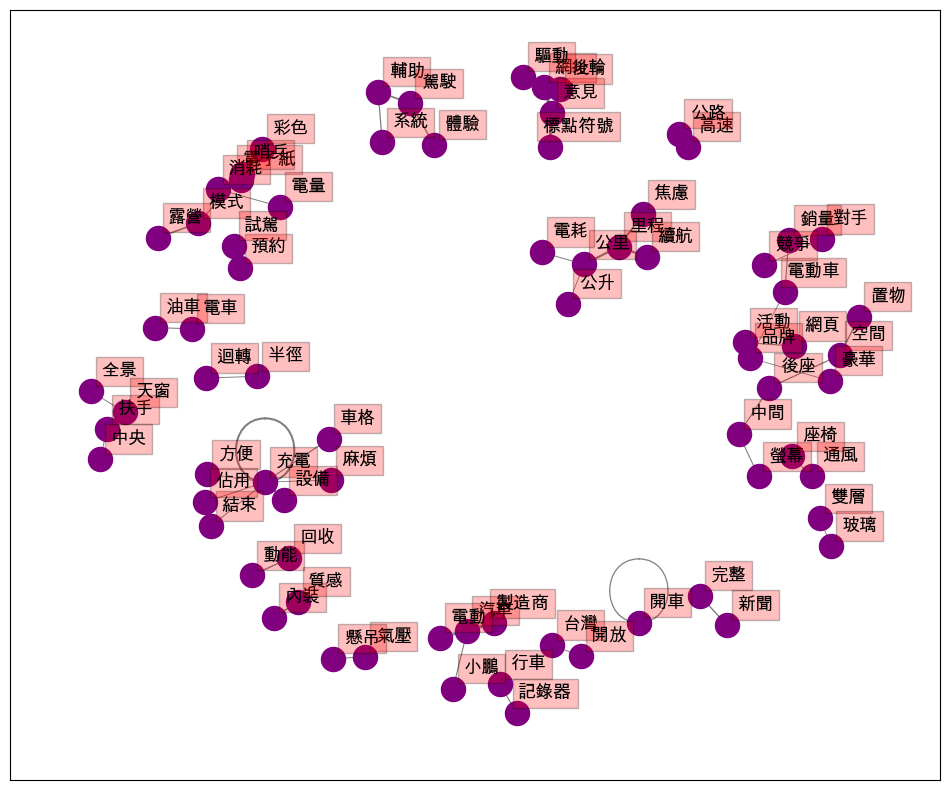

In [109]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=0.48)# k越大，斥力越小l;k越小，斥力越大

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.show()

## 服務方面深入分析

##### 在服務方面，透過LLM分出的結果以查看其所分出的正負面相關多字詞

In [110]:
df = pd.read_csv("data/ppt_tesla_classified_cleaned.csv")
df_service = df[df["class"]== "服務方面"]
df_service_pos =df_service[df_service['sentiment']=='正面']
df_service_neg =df_service[df_service['sentiment']=='負面']
df_service

system_id              artDate              artTitle  \
16           16  2023-01-06 22:03:36   新聞國道電動車充電站第三期準備招標個服   
208         208  2023-03-06 18:15:18        電車特斯拉的停車輔助要加回來   
240         240  2023-03-15 10:29:52     新聞電子廠商爭先搶入電動車索尼鴻海   
386         386  2023-04-28 22:57:48      新聞萬天坑特斯拉報廢建商只丟句話   
507         507  2023-06-07 14:06:37    新聞特斯拉車款遭拒保國泰產險開第一槍   
526         526  2023-06-15 11:22:55     新聞驚喜不斷限時推出指定車款套件升   
596         596  2023-07-12 07:59:12     新聞亞馬遜與合作投入電動貨運車隊進   
650         650  2023-08-01 00:02:26      新聞新版內建自動輔助導航自駕功能   
922         922  2023-11-07 17:38:20  新聞國內半導體業者持續深耕具發展潛力的車   
954         954  2023-11-16 17:24:07        市調汽車市場研究活動車馬費元   
1010       1010  2023-12-02 20:16:06   新聞沒充電站特斯拉車主從住家樓拉電線台   
1211       1211  2024-01-22 23:11:15          分享車禍後租車費賠償判准   
1317       1317  2024-02-18 11:37:06     新聞鴻海納智捷電動車上半年交貨完畢   
1379       1379  2024-04-14 11:38:47                    問題   
1407       1407  2024-04-21 17:58:50     問題請問特斯拉的業代到底幫客戶什麼   
1485       1485  2024-04-04 20:58:46       新聞小米汽車熱銷公司股價上漲逾   
1511       1511  2024-04-14 11:38:47                    問題   
1539       1539  2024-04-21 17:58:50     問題請問特斯拉的業代到底幫客戶什麼   

                                             artContent  \
16    原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
208   先前有訂本來月收到說月中交車已降價因故我想順延到下個季度再交車剛剛收到電話說特斯拉打算月底把...   
240   電子廠商爭先搶入電動車索尼鴻海高通蘋果和小米各有不同戰略原文連結原文內容電動車本質似乎不完全...   
386   原文連結原文內容竹北莊敬六路一處建築基地旁昨日發生馬路坍塌意外一輛才落地一個月的特斯拉當埸掉...   
507   大家好這個新聞剛出來的時候阿北我有點緊張該不會真的沒辦法保吧我還真的沒開過沒保險的車子耶最後...   
526   原文連結原文內容即日起至月日前訂購並於本月完成交付即可享有指定車款免費選配套件升級或首年免費...   
596   亞馬遜與合作投入電動貨運車隊進軍歐洲市場原文連結原文內容美國電商巨頭亞馬遜在歐洲推出訂製的電...   
650   原文連結原文內容美自駕新創更新開源自駕車軟體內建自動輔助導航自駕功能讓即使非高階的市售車也能...   
922   國內半導體業者持續深耕具發展潛力的車用電子市場原文連結原文內容有鑑於車用電子將於年成為全球半...   
954   本公司目前有項市場研究專案招募受訪者只要符合各專案的報名資格即可於本公司的活動網頁填寫報名資...   
1010  原文連結原文內容沒充電站特斯拉車主從住家樓拉電線台電說不行聯合報記者曾增勳桃園即時報導桃園市...   
1211  今天剛好看到一件判賠租車費的判例想說來分享給大家參考連結在最後簡單說明判決結果修車費依原告主...   
1317  作者沒問題看板標題新聞鴻海納智捷電動車上半年交貨完畢時間鴻海納智捷電動車上半年交貨完畢爭取所...   
1379            請問一下因為家裡有需求想要買一台想問近期有什麼優惠嗎或者什麼時候台灣會有的謝謝   
1407  我真的搞不懂訂一台特斯拉只會催你交車然後什麼保險隔熱紙配件完全不包全都要客人自己處理全台灣的...   
1485  看好小米因為它背後有一個大靠山北京市汽車業能帶動經濟所以各城市都非常競爭例如深圳比亞迪廣汽豐...   
1511            請問一下因為家裡有需求想要買一台想問近期有什麼優惠嗎或者什麼時候台灣會有的謝謝   
1539  我真的搞不懂訂一台特斯拉只會催你交車然後什麼保險隔熱紙配件完全不包全都要客人自己處理全台灣的...   

                                               sentence  \
16    原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
208   先前有訂本來月收到說月中交車已降價因故我想順延到下個季度再交車剛剛收到電話說特斯拉打算月底把...   
240   電子廠商爭先搶入電動車索尼鴻海高通蘋果和小米各有不同戰略原文連結原文內容電動車本質似乎不完全...   
386   原文連結原文內容竹北莊敬六路一處建築基地旁昨日發生馬路坍塌意外一輛才落地一個月的特斯拉當埸掉...   
507   大家好這個新聞剛出來的時候阿北我有點緊張該不會真的沒辦法保吧我還真的沒開過沒保險的車子耶最後...   
526   原文連結原文內容即日起至月日前訂購並於本月完成交付即可享有指定車款免費選配套件升級或首年免費...   
596   亞馬遜與合作投入電動貨運車隊進軍歐洲市場原文連結原文內容美國電商巨頭亞馬遜在歐洲推出訂製的電...   
650   原文連結原文內容美自駕新創更新開源自駕車軟體內建自動輔助導航自駕功能讓即使非高階的市售車也能...   
922   國內半導體業者持續深耕具發展潛力的車用電子市場原文連結原文內容有鑑於車用電子將於年成為全球半...   
954   本公司目前有項市場研究專案招募受訪者只要符合各專案的報名資格即可於本公司的活動網頁填寫報名資...   
1010  原文連結原文內容沒充電站特斯拉車主從住家樓拉電線台電說不行聯合報記者曾增勳桃園即時報導桃園市...   
1211  今天剛好看到一件判賠租車費的判例想說來分享給大家參考連結在最後簡單說明判決結果修車費依原告主...   
1317  作者沒問題看板標題新聞鴻海納智捷電動車上半年交貨完畢時間鴻海納智捷電動車上半年交貨完畢爭取所...   
1379            請問一下因為家裡有需求想要買一台想問近期有什麼優惠嗎或者什麼時候台灣會有的謝謝   
1407  我真的搞不懂訂一台特斯拉只會催你交車然後什麼保險隔熱紙配件完全不包全都要客人自己處理全台灣的...   
1485  看好小米因為它背後有一個大靠山北京市汽車業能帶動經濟所以各城市都非常競爭例如深圳比亞迪廣汽豐...   
1511            請問一下因為家裡有需求想要買一台想問近期有什麼優惠嗎或者什麼時候台灣會有的謝謝   
1539  我真的搞不懂訂一台特斯拉只會催你交車然後什麼保險隔熱紙配件完全不包全都要客人自己處理全台灣的...   

                                                    LLM sentiment class  
16                         {"文章分類": "服務方面","情緒": "正面",}        正面  服務方面  
208                        {"文章分類": "服務方面","情緒": "中性",}        中性  服務方面  
240                         {"文章分類": "服務方面","情緒": "正面"}        正面  服務方面  
386                        {"文章分類": "服務方面","情緒": "負面",}        負面  服務方面  
507                        {"文章分類": "服務方面","情緒": "中性",}        中性  服務方面  
526                        {"文章分類": "服務方面","情緒": "正面",}        正面  服務方面  
596                        {"文章分類": "服務方面","情緒": "正面",}        正面

In [111]:
df_service_neg

system_id              artDate             artTitle  \
386         386  2023-04-28 22:57:48     新聞萬天坑特斯拉報廢建商只丟句話   
1010       1010  2023-12-02 20:16:06  新聞沒充電站特斯拉車主從住家樓拉電線台   
1407       1407  2024-04-21 17:58:50    問題請問特斯拉的業代到底幫客戶什麼   
1539       1539  2024-04-21 17:58:50    問題請問特斯拉的業代到底幫客戶什麼   

                                             artContent  \
386   原文連結原文內容竹北莊敬六路一處建築基地旁昨日發生馬路坍塌意外一輛才落地一個月的特斯拉當埸掉...   
1010  原文連結原文內容沒充電站特斯拉車主從住家樓拉電線台電說不行聯合報記者曾增勳桃園即時報導桃園市...   
1407  我真的搞不懂訂一台特斯拉只會催你交車然後什麼保險隔熱紙配件完全不包全都要客人自己處理全台灣的...   
1539  我真的搞不懂訂一台特斯拉只會催你交車然後什麼保險隔熱紙配件完全不包全都要客人自己處理全台灣的...   

                                               sentence  \
386   原文連結原文內容竹北莊敬六路一處建築基地旁昨日發生馬路坍塌意外一輛才落地一個月的特斯拉當埸掉...   
1010  原文連結原文內容沒充電站特斯拉車主從住家樓拉電線台電說不行聯合報記者曾增勳桃園即時報導桃園市...   
1407  我真的搞不懂訂一台特斯拉只會催你交車然後什麼保險隔熱紙配件完全不包全都要客人自己處理全台灣的...   
1539  我真的搞不懂訂一台特斯拉只會催你交車然後什麼保險隔熱紙配件完全不包全都要客人自己處理全台灣的...   

                               LLM sentiment class  
386   {"文章分類": "服務方面","情緒": "負面",}        負面  服務方面  
1010  {"文章分類": "服務方面","情緒": "負面",}        負面  服務方面  
1407  {"文章分類": "服務方面","情緒": "負面",}        負面  服務方面  
1539   {"文章分類": "服務方面","情緒": "負面"}        負面  服務方面

In [112]:
def get_freq_to_wordcloud(input_df):
    jieba.set_dictionary("dict/dict.txt")
    df_service_pos＿word = input_df.assign(word = input_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
    df_service_pos＿word = df_service_pos＿word.loc[df_service_pos＿word['word'].str.len() > 1]
    stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
    after_clear_df_pos = df_service_pos＿word[~df_service_pos＿word['word'].isin(stopwords)]
    freq_df_clear_pos = pd.DataFrame(pd.value_counts(after_clear_df_pos['word'])).sort_values(by = ['count'], ascending = False).reset_index()
    freq_dict_nostop_pos = freq_df_clear_pos.set_index('word').to_dict()
    freq_dict_nostop_pos = freq_dict_nostop_pos['count']
    return freq_dict_nostop_pos


### 正面文字雲

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
2024-06-10 18:02:10,904 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
2024-06-10 18:02:10,904 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
Loading model cost 0.229 seconds.
2024-06-10 18:02:11,133 : DEBUG : Loading model cost 0.229 seconds.
Prefix dict has been built successfully.
2024-06-10 18:02:11,134 : DEBUG : Prefix dict has been built successfully.


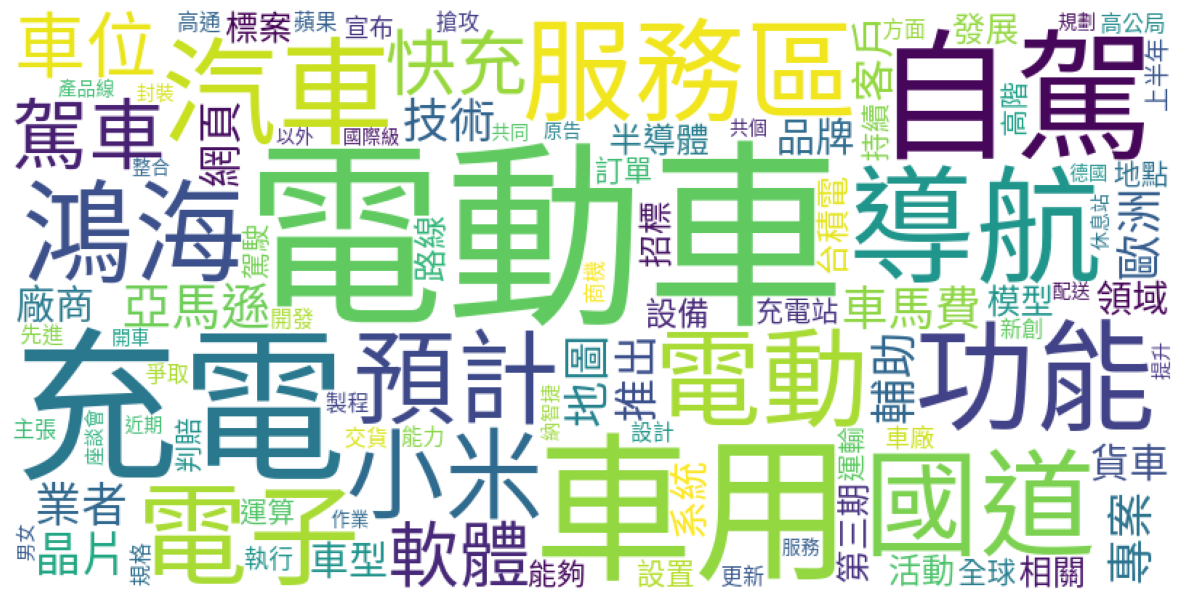

In [113]:
# 繪製文字雲
freq_service_pos = get_freq_to_wordcloud(df_service_pos)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_service_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### 負面文字雲

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
2024-06-10 18:02:11,723 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
2024-06-10 18:02:11,724 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
Loading model cost 0.223 seconds.
2024-06-10 18:02:11,946 : DEBUG : Loading model cost 0.223 seconds.
Prefix dict has been built successfully.
2024-06-10 18:02:11,947 : DEBUG : Prefix dict has been built successfully.


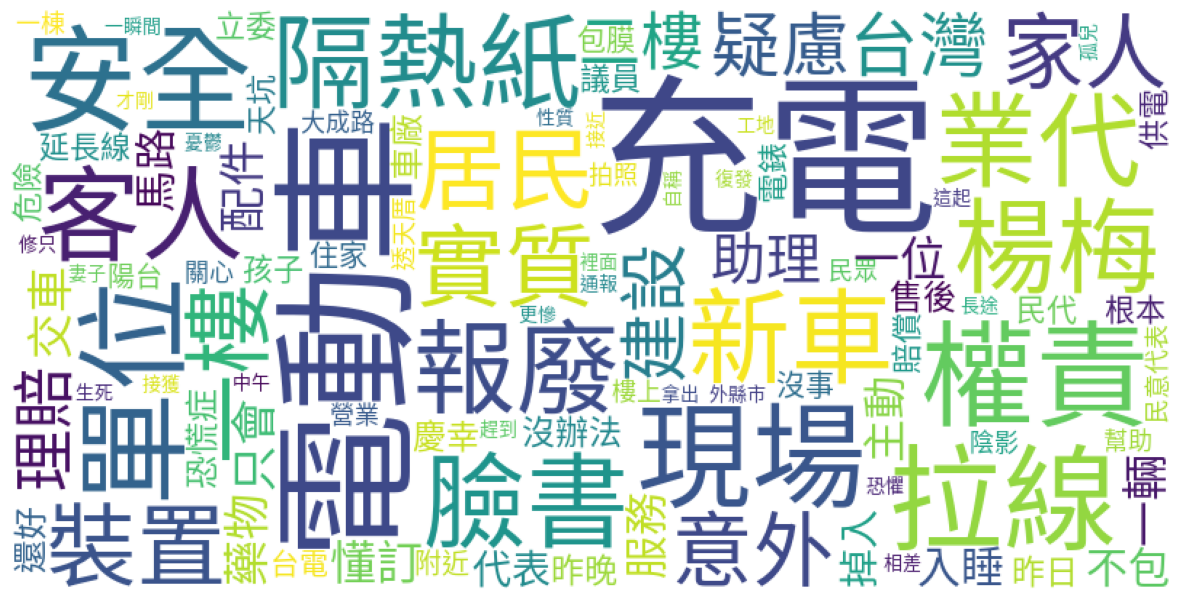

In [114]:
# 繪製文字雲
freq_service_pos = get_freq_to_wordcloud(df_service_neg)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_service_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### Bigram

In [ ]:
#匯入資料
df = pd.read_csv('./data/ppt_tesla.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
df = df[['artDate','artTitle','artContent']]
df['artDate'] = pd.to_datetime(df['artDate'])
df.head(3)

artDate                  artTitle  \
0 2023-01-01 10:48:19        Re:[情報]慟！特斯拉二手價跌好多   
1 2023-01-01 22:42:25            [問題]特斯拉久了會掉電嗎？   
2 2023-01-02 12:47:31  [新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛   

                                          artContent  
0  八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....  
1  各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...  
2  原文連結：\nhttps://star.setn.com/news/1232578?utm_...

In [ ]:
MetaData = df.copy()
MetaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
#MetaData['artDate'] =  pd.to_datetime(MetaData['artDate']).dt.to_period('D')

# 只留下中文字
MetaData['artContent'] = MetaData['artContent'].str.replace("(http|https)://.*", "", regex=True)
MetaData['artTitle'] = MetaData['artTitle'].str.replace("(http|https)://.*", "", regex=True)
MetaData['artContent'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['artTitle'] = MetaData['artTitle'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))


MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['sentence'] = MetaData['sentence'].apply(lambda x: re.sub('[口]', '', x))

MetaData.head(3)

artDate          artTitle  \
0 2023-01-01 10:48:19      情報慟特斯拉二手價跌好多   
1 2023-01-01 22:42:25       問題特斯拉久了會掉電嗎   
2 2023-01-02 12:47:31  新聞開特斯拉滑手機被勸嗆網友有毛   

                                          artContent  \
0                      八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎   
1  各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...   
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...   

                                            sentence  
0                      八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎  
1  各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...  
2  原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...

In [153]:
df_service['artContent'] = df_service['artContent'].astype(str)
# 只留下中文字
df_service['sentence'] = df_service['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_service.head(5)

In [116]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [117]:
exper_bigram = df_service.copy()

exper_bigram["word"] = exper_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
exper_bigram = exper_bigram.explode('word')

exper_bigram.head(3)

system_id              artDate             artTitle  \
16         16  2023-01-06 22:03:36  新聞國道電動車充電站第三期準備招標個服   
16         16  2023-01-06 22:03:36  新聞國道電動車充電站第三期準備招標個服   
16         16  2023-01-06 22:03:36  新聞國道電動車充電站第三期準備招標個服   

                                           artContent  \
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   

                                             sentence  \
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   

                             LLM sentiment class     word  
16  {"文章分類": "服務方面","情緒": "正面",}        正面  服務方面   國道 電動車  
16  {"文章分類": "服務方面","情緒": "正面",}        正面  服務方面  電動車 充電站  
16  {"文章分類": "服務方面","情緒": "正面",}        正面  服務方面  充電站 第三期

In [118]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0     導航 自駕     14
1     充電 車位      9
2     電動 貨車      6
3     自駕 功能      6
4     活動 網頁      6
5     充電 設備      6
6    電動車 充電      5
7     輔助 導航      5
8     國道 快充      5
9     車用 晶片      5
10    權責 單位      5
11    駕車 軟體      5
14    車用 電子      4
15   上半年 交貨      4
13  電動車 充電站      4
12    源自 駕車      4
27   第三期 標案      3
37    潛在 客戶      3
36    歐洲 運輸      3
34    成熟 製程      3


In [119]:
exper_trigram = df_service.copy()

exper_trigram["word"] = exper_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
exper_trigram = exper_trigram.explode('word')

exper_trigram.head(3)

system_id              artDate             artTitle  \
16         16  2023-01-06 22:03:36  新聞國道電動車充電站第三期準備招標個服   
16         16  2023-01-06 22:03:36  新聞國道電動車充電站第三期準備招標個服   
16         16  2023-01-06 22:03:36  新聞國道電動車充電站第三期準備招標個服   

                                           artContent  \
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   

                                             sentence  \
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   

                             LLM sentiment class         word  
16  {"文章分類": "服務方面","情緒": "正面",}        正面  服務方面   國道 電動車 充電站  
16  {"文章分類": "服務方面","情緒": "正面",}        正面  服務方面  電動車 充電站 第三期  
16  {"文章分類": "服務方面","情緒": "正面",}        正面  服務方面   充電站 第三期 準備

Trigram

In [120]:
# 計算每個組合出現的次數
exper_trigram_count = exper_trigram['word'].value_counts().reset_index()

# 重命名列
exper_trigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_trigram_count_sorted = exper_trigram_count.sort_values('count', ascending=False).head(20)

print(exper_trigram_count_sorted)

          word  count
0     導航 自駕 功能      5
1     輔助 導航 自駕      5
2     源自 駕車 軟體      4
3     先進 駕駛 輔助      3
4    上半年 交貨 完畢      3
53    首選 車型 必且      2
60    請問 家裡 想要      2
59   車皆可 近期 預計      2
58    近期 預計 小型      2
57   預計 小型 休旅車      2
56   小型 休旅車 預算      2
55   休旅車 預算 首選      2
54    預算 首選 車型      2
50   相關 了解 車馬費      2
52    車型 必且 相關      2
51    必且 相關 了解      2
62    想要 想問 近期      2
49   座談會 報到 地點      2
48    駕駛 輔助 系統      2
47  個人用 車皆可 近期      2


In [121]:
bigramudist = df_service.copy()

bigramudist["word"] = bigramudist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramudist = bigramudist.explode('word')
bigramudist.dropna(subset = ['word'], axis=0, how='any', inplace=True)
bigramudist.head(3)


system_id              artDate             artTitle  \
16         16  2023-01-06 22:03:36  新聞國道電動車充電站第三期準備招標個服   
16         16  2023-01-06 22:03:36  新聞國道電動車充電站第三期準備招標個服   
16         16  2023-01-06 22:03:36  新聞國道電動車充電站第三期準備招標個服   

                                           artContent  \
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   

                                             sentence  \
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   
16  原文連結原文內容國道電動車充電站第三期準備招標個服務區蓋座快充站最低功率起跳國道電動車充電站...   

                             LLM sentiment class     word  
16  {"文章分類": "服務方面","情緒": "正面",}        正面  服務方面   國道 電動車  
16  {"文章分類": "服務方面","情緒": "正面",}        正面  服務方面  電動車 充電站  
16  {"文章分類": "服務方面","情緒": "正面",}        正面  服務方面  充電站 第三期

In [122]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0     導航 自駕     14
1     充電 車位      9
2     電動 貨車      6
3     自駕 功能      6
4     活動 網頁      6
5     充電 設備      6
6    電動車 充電      5
7     輔助 導航      5
8     國道 快充      5
9     車用 晶片      5
10    權責 單位      5
11    駕車 軟體      5
14    車用 電子      4
15   上半年 交貨      4
13  電動車 充電站      4
12    源自 駕車      4
27   第三期 標案      3
37    潛在 客戶      3
36    歐洲 運輸      3
34    成熟 製程      3


In [123]:
bigramudist['word'] = bigramudist['word'].astype(str)
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramudist = FreqDist(bigramudist['word'].apply(lambda x: tuple(x.split(' '))))
bigramudist.most_common(5)

[(('導航', '自駕'), 14),
 (('充電', '車位'), 9),
 (('充電', '設備'), 6),
 (('電動', '貨車'), 6),
 (('自駕', '功能'), 6)]

In [124]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramudist.most_common(50)}
d.items()

dict_items([(('導航', '自駕'), 14), (('充電', '車位'), 9), (('充電', '設備'), 6), (('電動', '貨車'), 6), (('自駕', '功能'), 6), (('活動', '網頁'), 6), (('電動車', '充電'), 5), (('國道', '快充'), 5), (('權責', '單位'), 5), (('駕車', '軟體'), 5), (('輔助', '導航'), 5), (('車用', '晶片'), 5), (('電動車', '充電站'), 4), (('源自', '駕車'), 4), (('車用', '電子'), 4), (('上半年', '交貨'), 4), (('第三期', '標案'), 3), (('索尼', '鴻海'), 3), (('高通', '蘋果'), 3), (('作業', '系統'), 3), (('運算', '能力'), 3), (('即日', '起至'), 3), (('亞馬遜', '歐洲'), 3), (('歐洲', '運輸'), 3), (('先進', '駕駛'), 3), (('駕駛', '輔助'), 3), (('自駕', '新創'), 3), (('自駕', '模型'), 3), (('國內', '半導體'), 3), (('成熟', '製程'), 3), (('潛在', '客戶'), 3), (('搶攻', '車用'), 3), (('民國', '男女'), 3), (('充電', '裝置'), 3), (('安全', '疑慮'), 3), (('原告', '主張'), 3), (('納智捷', '電動車'), 3), (('交貨', '完畢'), 3), (('國道', '電動車'), 2), (('服務區', '要蓋座'), 2), (('標案', '預計'), 2), (('預計', '三月'), 2), (('三月', '招標'), 2), (('中興', '電工'), 2), (('共個', '充電'), 2), (('新營', '服務區'), 2), (('草屯', '休息站'), 2), (('車位', '國道'), 2), (('國道', '服務區'), 2), (('服務區', '電動車'), 2)])

In [125]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    print(k[0])
    print(v)
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.1 for w in  G.edges(data=True)]

導航
14
充電
9
充電
6
電動
6
自駕
6
活動
6
電動車
5
國道
5
權責
5
駕車
5
輔助
5
車用
5
電動車
4
源自
4
車用
4
上半年
4
第三期
3
索尼
3
高通
3
作業
3
運算
3
即日
3
亞馬遜
3
歐洲
3
先進
3
駕駛
3
自駕
3
自駕
3
國內
3
成熟
3
潛在
3
搶攻
3
民國
3
充電
3
安全
3
原告
3
納智捷
3
交貨
3
國道
2
服務區
2
標案
2
預計
2
三月
2
中興
2
共個
2
新營
2
草屯
2
車位
2
國道
2
服務區
2


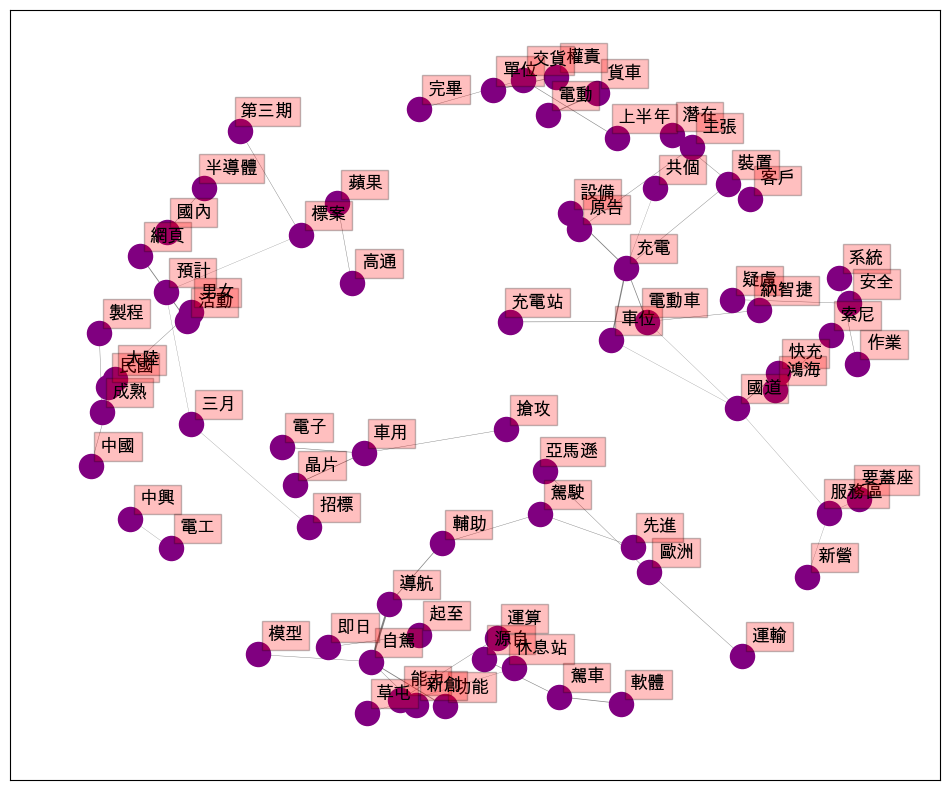

In [159]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=0.6)# k越大，斥力越小l;k越小，斥力越大

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.show()

## 分析與結論

### 安全性方面：
### 性價比方面：
### 使用者體驗方面：
### 服務方面：從負面文字雲可以看到，「包膜、隔熱紙、售後、服務、業代、新車」等字理解到原文提及，特斯拉新車購買時並沒有完善的售後服務，相比於其他傳統車商，新車出廠時，傳統車商可以服務包膜加貼隔熱紙等需求，而特斯拉則無，並評論到特斯拉業代在台灣服務不齊全。

## 給車商的改進與方向
+ 特斯拉可以配合周邊廠商合作，配合車主加貼隔熱者或者包膜等需求，提高服務品質